# Load Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import joblib
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

from keras.layers.core import Dense, Dropout, Activation
import keras.callbacks as callbacks
from keras.utils import np_utils

import Models
from AuxiliarFunctions import *

# Load Data

In [2]:
config_file_path = 'data/config.csv'
df_config = pd.read_csv(config_file_path)
train_id = 0

In [3]:
dev_social = pd.read_csv(os.path.join(df_config['processed_file_folder'][train_id],'dev_social.csv'))
dev_personal = pd.read_csv(os.path.join(df_config['processed_file_folder'][train_id],'dev_personal.csv'))
dev_clinical = pd.read_csv(os.path.join(df_config['processed_file_folder'][train_id],'dev_clinical.csv'))
dev_pos_test = pd.read_csv(os.path.join(df_config['processed_file_folder'][train_id],'dev_pos_test.csv'))
dev_target = pd.read_csv(os.path.join(df_config['processed_file_folder'][train_id],'dev_target.csv'))

# Treinamento de um modelo simples para decisão do médico

Durante o processo de desenvolvimento, tive uma discussão com o André sobre o processo de tomada de decisão de um médico e ele se baseia em 3 variáveis: proteina, citometria e dif cif. Ou seja, será que um modelo consegue fazer o mesmo que um médico apenas analisando estas variáveis?

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

model_type = 'DecisionTree'
n_folds =  df_config['cv_folds'][train_id]

cv_path = df_config['cv_path'][train_id]
pipe_path = df_config['pipeline_path'][train_id]

n_folds = df_config['cv_folds'][train_id]

dataset_name = 'pos_test'

print(get_train_description(df_config, train_id))

print('Processing Decision Tree Training')
data = dev_pos_test
for ifold in range(n_folds):
    #if ifold != 0: # para desenvolvimento
    #    break

    print('Training %i fold of %i folds\n\n'%(ifold+1, n_folds))

    cv_name = '%s_%s_CV_fold_%i_of_%i_cv_indexes.pkl'%(df_config['hash_id'][train_id],
                                                     df_config['cv_alg'][train_id],
                                                     ifold, n_folds)
    with open(os.path.join(cv_path,cv_name),'rb') as file_handler:
        [trn_idx,val_idx] = pickle.load(file_handler)

    pipe_name = '%s_%s_CV_fold_%i_of_%i_pipe_%s.jbl'%(df_config['hash_id'][train_id],
                                                      df_config['cv_alg'][train_id],
                                                      ifold, n_folds, 
                                                      dataset_name)
    with open(os.path.join(pipe_path,pipe_name),'rb') as file_handler:
        pipe = joblib.load(file_handler)

    trn_data = pipe.transform(data)
    trn_trgt = dev_target.values # tf.keras.utils.to_categorical(dev_target, num_classes=len(np.unique(dev_target)))
    print('Training for model')
    model_name = '%s_%s_%i_fold_model_%s.pkl'%(df_config['hash_id'][train_id],
                                               model_type, ifold, 
                                               dataset_name)
    model_path = df_config['model_path'][train_id]
    if os.path.exists(os.path.join(model_path, model_name)):
        print('Modelo existente em %s'%(os.path.join(model_path, model_name)))
    else:
        print('Modelo não existe\n\n')
        model = DecisionTreeClassifier(max_leaf_nodes=4, random_state=0)
        model.fit(trn_data, trn_trgt)
        predictions = model.predict(trn_data)
        df_predict = pd.DataFrame(data=np.concatenate((dev_target.values, 
                                                       predictions[:,np.newaxis]),
                                                      axis=1), 
                                  columns=['target', 'model_output'])
        prediction_name = '%s_%s_%i_fold_prediction_file_%s.csv'%(df_config['hash_id'][train_id],
                                                                  model_type, ifold,
                                                                  dataset_name)
        df_predict.to_csv(os.path.join(model_path, prediction_name),index=False)
        
        pickle.dump(model, open(os.path.join(model_path, model_name), 'wb'))
        # to load: model = pickle.load(open((os.path.join(model_path, model_name), 'rb'))




TB Data Classification with StratifiedKFolds Training Process
Processing data/8691172013082741024_train_data.csv
Hidden Neurons: 2, 3, 4, 5
CV Folds: 5
Inits: 1

Processing Decision Tree Training
Training 1 fold of 5 folds


Training for model
Modelo existente em data/models/8691172013082741024_DecisionTree_0_fold_model_pos_test.pkl
Training 2 fold of 5 folds


Training for model
Modelo não existe


Training 3 fold of 5 folds


Training for model
Modelo não existe


Training 4 fold of 5 folds


Training for model
Modelo não existe


Training 5 fold of 5 folds


Training for model
Modelo não existe




## Análise Básica

In [30]:
model_type = 'DecisionTree'

dataset_name = 'pos_test'#'personal', 'social', 'clinical', 'pos_test', 'PeSo', 'PeSoCli', 'PeCli', 'CliPos', 'PeSoCliPos_par'
figure_of_merit_names = ['sens', 'spec', 'acc', 'sp']

n_folds =  df_config['cv_folds'][train_id]
cv_path = df_config['cv_path'][train_id]
pipe_path = df_config['pipeline_path'][train_id]
model_path = df_config['model_path'][train_id]

df_train = pd.DataFrame(data=np.zeros([df_config['cv_folds'][train_id],len(figure_of_merit_names)]), columns=figure_of_merit_names)
df_val = pd.DataFrame(np.zeros([df_config['cv_folds'][train_id],len(figure_of_merit_names)]))

for ifold in range(df_config['cv_folds'][train_id]):
    print('Processing fold %i of %i'%(ifold, df_config['cv_folds'][train_id]))
    
    cv_name = '%s_%s_CV_fold_%i_of_%i_cv_indexes.pkl'%(df_config['hash_id'][train_id],
                                                         df_config['cv_alg'][train_id],
                                                         ifold, n_folds)
    with open(os.path.join(cv_path,cv_name),'rb') as file_handler:
        [trn_idx,val_idx] = pickle.load(file_handler)
    
    prediction_file_name = '%s_%s_%i_fold_prediction_file_%s.csv'%(df_config['hash_id'][train_id],
                                                                  model_type, ifold,
                                                                  dataset_name)
    print('Reading: ',prediction_file_name)
    df_predict = pd.read_csv(os.path.join(model_path, prediction_file_name))
    #print(df_predict['nn_output'].head())
    #print('\n')
    for figure_of_merit in figure_of_merit_names:
        
        if figure_of_merit == 'sens':
            df_train.loc[ifold,figure_of_merit] = Models.sensitivity_score(df_predict.loc[trn_idx,'target'], 
                                                                           df_predict.loc[trn_idx,'model_output'])
            df_val.loc[ifold,figure_of_merit] = Models.sensitivity_score(df_predict.loc[val_idx,'target'], 
                                                                         df_predict.loc[val_idx,'model_output'])
        if figure_of_merit == 'spec':
            df_train.loc[ifold,figure_of_merit] = Models.specificity_score(df_predict.loc[trn_idx,'target'], 
                                                                           df_predict.loc[trn_idx,'model_output'])
            df_val.loc[ifold,figure_of_merit] = Models.specificity_score(df_predict.loc[val_idx,'target'], 
                                                                         df_predict.loc[val_idx,'model_output'])
        if figure_of_merit == 'acc':
            df_train.loc[ifold,figure_of_merit] = Models.acc_score(df_predict.loc[trn_idx,'target'], 
                                                                   df_predict.loc[trn_idx,'model_output'])
            df_val.loc[ifold,figure_of_merit] = Models.acc_score(df_predict.loc[val_idx,'target'], 
                                                                         df_predict.loc[val_idx,'model_output'])
        if figure_of_merit == 'sp':
            df_train.loc[ifold,figure_of_merit] = Models.sp_index(df_predict.loc[trn_idx,'target'], 
                                                                  df_predict.loc[trn_idx,'model_output'])
            df_val.loc[ifold,figure_of_merit] = Models.sp_index(df_predict.loc[val_idx,'target'], 
                                                                df_predict.loc[val_idx,'model_output'])
df_fig_of_merit = pd.concat([df_train.mean(axis=0).T,df_train.std(axis=0).T],axis=1)
df_fig_of_merit = df_fig_of_merit.rename(columns={0:'mean',1:'std'}, )
df_fig_of_merit = df_fig_of_merit.T

Processing fold 0 of 5
Reading:  8691172013082741024_DecisionTree_0_fold_prediction_file_pos_test.csv
Processing fold 1 of 5
Reading:  8691172013082741024_DecisionTree_1_fold_prediction_file_pos_test.csv
Processing fold 2 of 5
Reading:  8691172013082741024_DecisionTree_2_fold_prediction_file_pos_test.csv
Processing fold 3 of 5
Reading:  8691172013082741024_DecisionTree_3_fold_prediction_file_pos_test.csv
Processing fold 4 of 5
Reading:  8691172013082741024_DecisionTree_4_fold_prediction_file_pos_test.csv


In [31]:
df_fig_of_merit

,sens,spec,acc,sp
mean,0.891494,0.589011,0.795983,0.53648
std,0.060700,0.024076,0.039567,0.03735


Processing fold 0 of 5


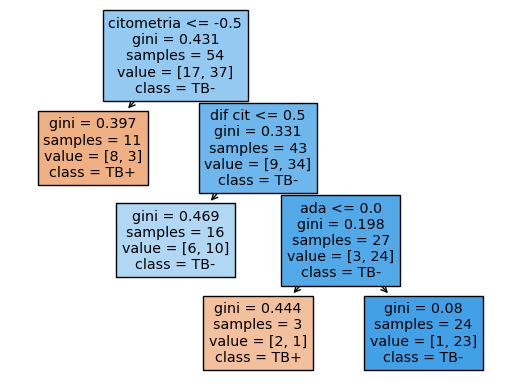

Processing fold 1 of 5


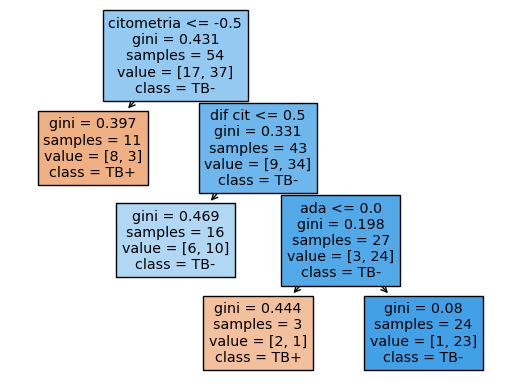

Processing fold 2 of 5


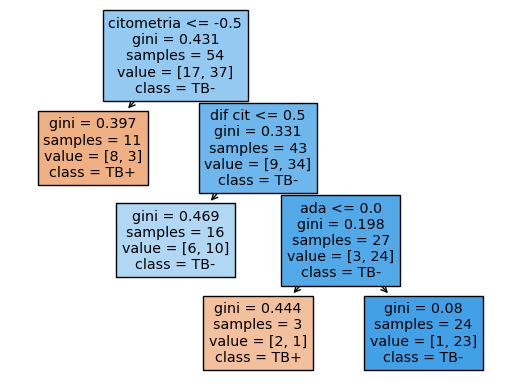

Processing fold 3 of 5


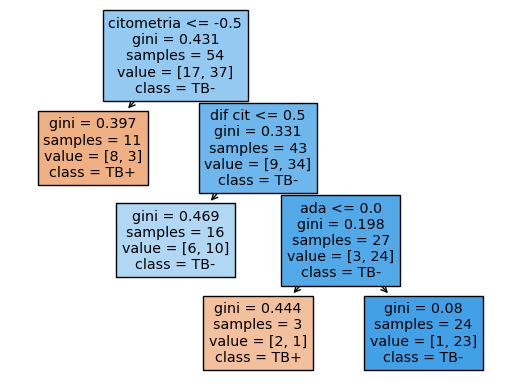

Processing fold 4 of 5


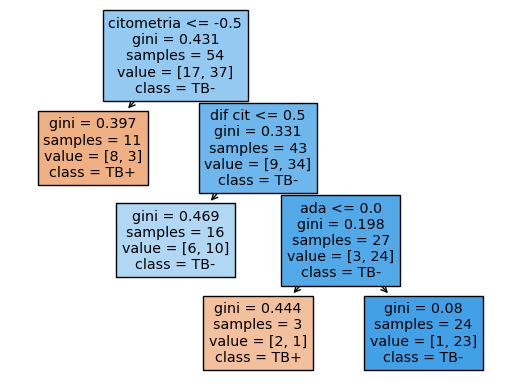

In [36]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

model_type = 'DecisionTree'

dataset_name = 'pos_test'#'personal', 'social', 'clinical', 'pos_test', 'PeSo', 'PeSoCli', 'PeCli', 'CliPos', 'PeSoCliPos_par'
figure_of_merit_names = ['sens', 'spec', 'acc', 'sp']

n_folds =  df_config['cv_folds'][train_id]
cv_path = df_config['cv_path'][train_id]
pipe_path = df_config['pipeline_path'][train_id]
model_path = df_config['model_path'][train_id]

for ifold in range(df_config['cv_folds'][train_id]):
    print('Processing fold %i of %i'%(ifold, df_config['cv_folds'][train_id]))
    
    cv_name = '%s_%s_CV_fold_%i_of_%i_cv_indexes.pkl'%(df_config['hash_id'][train_id],
                                                         df_config['cv_alg'][train_id],
                                                         ifold, n_folds)
    with open(os.path.join(cv_path,cv_name),'rb') as file_handler:
        [trn_idx,val_idx] = pickle.load(file_handler)
    
    model_name = '%s_%s_%i_fold_model_%s.pkl'%(df_config['hash_id'][train_id],
                                               model_type, ifold, 
                                               dataset_name)
    model = pickle.load(open(os.path.join(model_path, model_name), 'rb'))
    fn=list(dev_pos_test.columns)
    cn=['TB+', 'TB-']
    tree.plot_tree(model,feature_names = fn,class_names=cn,filled = True)
    plt.show()

In [26]:
df_predict

,target,model_output
0,1,1
1,1,1
2,1,1
3,-1,-1
4,1,1
5,1,1
6,1,1
7,1,1
8,1,1
9,1,1


In [10]:
dev_target.shape

(54, 1)

# Training Process

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

model_type = 'MLPNeuralNetwork'
n_folds =  df_config['cv_folds'][train_id]

cv_path = df_config['cv_path'][train_id]
pipe_path = df_config['pipeline_path'][train_id]

n_folds = df_config['cv_folds'][train_id]
hidden_neurons = list(get_list_of_hidden_neurons(df_config['model_neurons'][train_id]))

datasets_data = [dev_social, dev_clinical, dev_pos_test, dev_personal]
datasets_name = ['social', 'clinical', 'pos_test', 'personal']

# para desenvolvimento
#datasets_data = [dev_social]
#datasets_name = ['social']


print(get_train_description(df_config, train_id))

for idataset, dataset_name in enumerate(datasets_name): 
    print('Processing %s'%(dataset_name))
    data = datasets_data[idataset]
    for ifold in range(n_folds):
        #if ifold != 0: # para desenvolvimento
        #    break
        
        print('Training %i fold of %i folds\n\n'%(ifold+1, n_folds))

        cv_name = '%s_%s_CV_fold_%i_of_%i_cv_indexes.pkl'%(df_config['hash_id'][train_id],
                                                         df_config['cv_alg'][train_id],
                                                         ifold, n_folds)
        with open(os.path.join(cv_path,cv_name),'rb') as file_handler:
            [trn_idx,val_idx] = pickle.load(file_handler)

        pipe_name = '%s_%s_CV_fold_%i_of_%i_pipe_%s.jbl'%(df_config['hash_id'][train_id],
                                                          df_config['cv_alg'][train_id],
                                                          ifold, n_folds, 
                                                          datasets_name[idataset])
        with open(os.path.join(pipe_path,pipe_name),'rb') as file_handler:
            pipe = joblib.load(file_handler)

        trn_data = pipe.transform(data)
        trn_trgt = dev_target.values # tf.keras.utils.to_categorical(dev_target, num_classes=len(np.unique(dev_target)))
        for idx, ineuron in enumerate(hidden_neurons):
            print('Training for %i neuron in'%(ineuron),hidden_neurons)
            for iinit in range(df_config['model_inits'][train_id]):
                print('Training for %i init in %i inits'%(iinit+1, df_config['model_inits'][train_id]))
                model_name = '%s_%s_%i_fold_%i_neuron_%i_init_model_%s.pkl'%(df_config['hash_id'][train_id],
                                                                             model_type,ifold, 
                                                                             ineuron, iinit,
                                                                             datasets_name[idataset])
                model_path = df_config['model_path'][train_id]
                if os.path.exists(os.path.join(model_path, model_name)):
                    print('Modelo existente em %s'%(os.path.join(model_path, model_name)))
                    #model = Models.MLPModel(n_hidden_neurons=ineuron,verbose=2)
                    #model.load(os.path.join(model_path, model_name))
                else:
                    print('Modelo não existe\n\n')
                    model = Models.MLPModel(n_hidden_neurons=ineuron,verbose=2)
                    model.fit(trn_data, trn_trgt, trn_id=trn_idx, val_id=val_idx, 
                              epochs=100,#df_config['model_epochs'][train_id], 
                              random_state=iinit, 
                              learning_rate=0.01,#df_config['model_learning_rate'][train_id],
                              patience=100,#df_config['model_patience'][train_id],
                              batch_size=int(df_config['model_batch_size'][train_id]),
                             )
                    predictions = model.predict(trn_data)
                    df_predict = pd.DataFrame(data=np.concatenate((dev_target.values, 
                                                                   predictions,
                                                                   np.sign(predictions)),
                                                                  axis=1), 
                                              columns=['target', 'nn_output', 'prediction'])
                    prediction_name = '%s_%s_%i_fold_%i_neuron_%i_init_prediction_file_%s.csv'%(df_config['hash_id'][train_id],
                                                                                                model_type,ifold, ineuron, iinit,
                                                                                                datasets_name[idataset])
                    df_predict.to_csv(os.path.join(model_path, prediction_name),index=False)
                    model.save(os.path.join(model_path, model_name))




TB Data Classification with StratifiedKFolds Training Process
Processing data/8691172013082741024_train_data.csv
Hidden Neurons: 2, 3, 4, 5
CV Folds: 5
Inits: 1

Processing social
Training 1 fold of 5 folds


Training for 2 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_model_social.pkl
Training for 3 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_3_neuron_0_init_model_social.pkl
Training for 4 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_4_neuron_0_init_model_social.pkl
Training for 5 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_5_neuron_0_init_model_social.pkl
Training 2 fold of 5 folds


Training for 2 neuron in [2, 3, 4, 5]
Training 

Training for 2 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_2_neuron_0_init_model_pos_test.pkl
Training for 3 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_3_neuron_0_init_model_pos_test.pkl
Training for 4 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_4_neuron_0_init_model_pos_test.pkl
Training for 5 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_5_neuron_0_init_model_pos_test.pkl
Training 5 fold of 5 folds


Training for 2 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_pos_test.pkl
Training for 3 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Mo

# Análise de Topologia

In [5]:
from sklearn.metrics import accuracy_score
from AuxiliarFunctions import *


print(get_train_description(df_config, train_id))


if True: # remova quando tiver segurança no treinamento
    model_type = 'MLPNeuralNetwork'
    
    datasets_data = [dev_social, dev_clinical, dev_pos_test, dev_personal]
    datasets_name = ['social', 'clinical', 'pos_test', 'personal']

    
    hidden_neurons = list(get_list_of_hidden_neurons(df_config['model_neurons'][train_id]))
    
    n_folds = df_config['cv_folds'][train_id]
    
    figure_of_merit_matrix = np.zeros([len(datasets_name),len(hidden_neurons),n_folds])
    best_init_matrix = np.zeros([len(datasets_name),len(hidden_neurons),n_folds])
    
    for idataset, dataset_name in enumerate(datasets_name): 
        print('Processing %s'%(dataset_name))
        data = datasets_data[idataset]
    
        for ifold in range(n_folds):
            print('Analysing %i fold of %i folds'%(ifold+1, n_folds))

            for idx, ineuron in enumerate(hidden_neurons):
                print('Analysing for %i neuron in'%(ineuron),hidden_neurons)

                best_figure_of_merit = -9999

                for iinit in range(df_config['model_inits'][train_id]):
                    print('Analysing for %i init in %i inits'%(iinit+1, df_config['model_inits'][train_id]))
                    # repare que mudou!
                    model_name = '%s_%s_%i_fold_%i_neuron_%i_init_prediction_file_%s.csv'%(df_config['hash_id'][train_id],
                                                                                           model_type,ifold, ineuron, iinit,
                                                                                           datasets_name[idataset])
                    model_path = df_config['model_path'][train_id]
                    #print(os.path.join(model_path, model_name))
                    if os.path.exists(os.path.join(model_path, model_name)):
                        print('Modelo existente em %s'%(os.path.join(model_path, model_name)))
                        # adicionar a função de analise acc ou outra
                        df_predictions = pd.read_csv(os.path.join(model_path, model_name))
                        figure_of_merit = Models.acc_score(df_predictions['target'].values, 
                                                           df_predictions['prediction'].values)
                        print('Figure of Merit: Acc, value %1.3f'%(figure_of_merit))
                        if best_figure_of_merit < figure_of_merit:
                            figure_of_merit_matrix[idataset,idx, ifold] = figure_of_merit
                            best_figure_of_merit = figure_of_merit
                            best_init_matrix[idataset,idx,ifold] = iinit

                    else:
                        print('Modelo não existe\n\n')
                        # fora!
        




TB Data Classification with StratifiedKFolds Training Process
Processing data/8691172013082741024_train_data.csv
Hidden Neurons: 2, 3, 4, 5
CV Folds: 5
Inits: 1

Processing social
Analysing 1 fold of 5 folds
Analysing for 2 neuron in [2, 3, 4, 5]
Analysing for 1 init in 1 inits
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_prediction_file_social.csv
Figure of Merit: Acc, value 0.741
Analysing for 3 neuron in [2, 3, 4, 5]
Analysing for 1 init in 1 inits
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_3_neuron_0_init_prediction_file_social.csv
Figure of Merit: Acc, value 0.778
Analysing for 4 neuron in [2, 3, 4, 5]
Analysing for 1 init in 1 inits
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_4_neuron_0_init_prediction_file_social.csv
Figure of Merit: Acc, value 0.778
Analysing for 5 neuron in [2, 3, 4, 5]
Analysing for 1 init in 1 inits
Modelo existente em data/models/86911720130827

Figure of Merit: Acc, value 0.852
Analysing for 5 neuron in [2, 3, 4, 5]
Analysing for 1 init in 1 inits
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_5_neuron_0_init_prediction_file_clinical.csv
Figure of Merit: Acc, value 0.852
Processing pos_test
Analysing 1 fold of 5 folds
Analysing for 2 neuron in [2, 3, 4, 5]
Analysing for 1 init in 1 inits
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_prediction_file_pos_test.csv
Figure of Merit: Acc, value 0.815
Analysing for 3 neuron in [2, 3, 4, 5]
Analysing for 1 init in 1 inits
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_3_neuron_0_init_prediction_file_pos_test.csv
Figure of Merit: Acc, value 0.796
Analysing for 4 neuron in [2, 3, 4, 5]
Analysing for 1 init in 1 inits
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_4_neuron_0_init_prediction_file_pos_test.csv
Figure of Merit: Acc, value 0.778
Analysing for 

Figure of Merit: Acc, value 0.852
Analysing for 5 neuron in [2, 3, 4, 5]
Analysing for 1 init in 1 inits
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_5_neuron_0_init_prediction_file_personal.csv
Figure of Merit: Acc, value 0.833


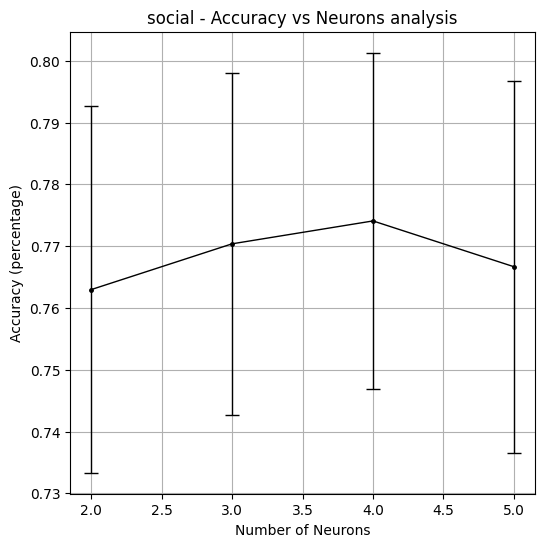

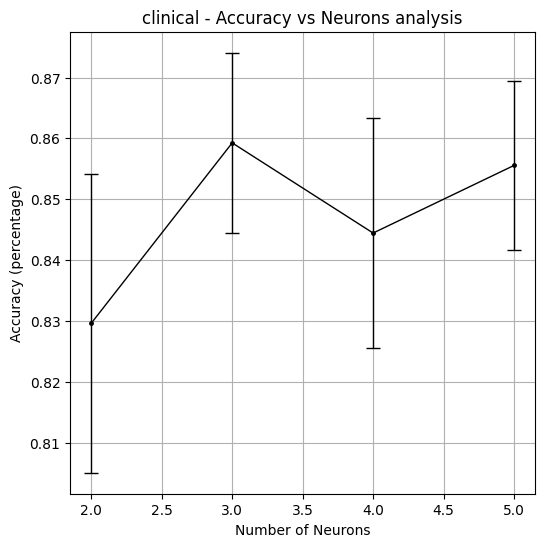

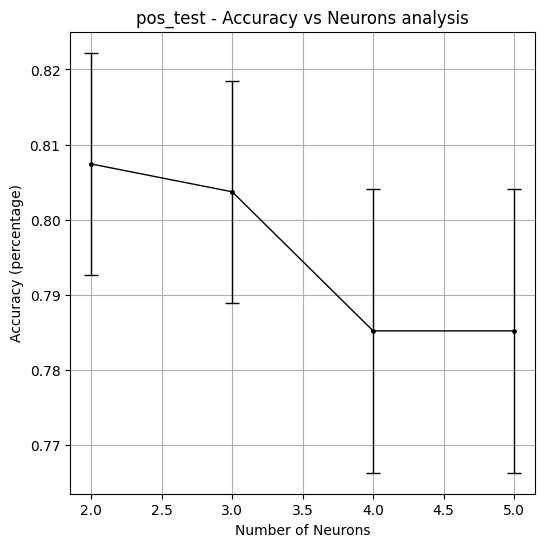

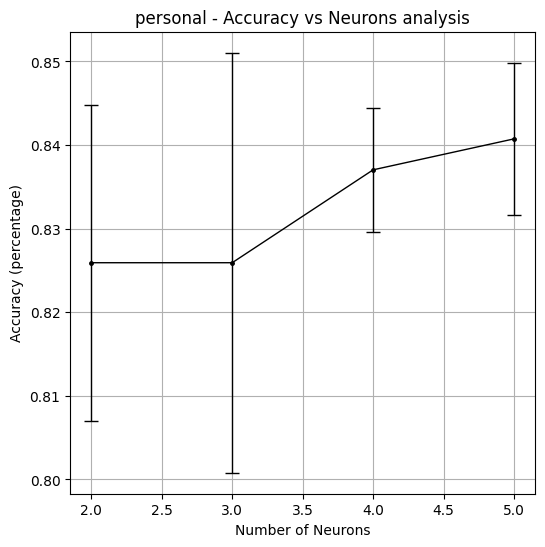

In [6]:
import matplotlib.pyplot as plt

figure_of_merit_label = 'Accuracy'

for idataset, dataset_name in enumerate(datasets_name): 
    plt.figure(figsize=(6, 6))
    hidden_neurons = list(get_list_of_hidden_neurons(df_config['model_neurons'][train_id]))
    mean_figure_of_merit = np.mean(figure_of_merit_matrix[idataset,:,:],axis=1)
    std_figure_of_merit = np.std(figure_of_merit_matrix[idataset,:,:],axis=1) 

    linestyle = {"linestyle":"-", "linewidth":1, "markersize":2.5, "markeredgewidth":1, "elinewidth":1, "capsize":5}

    plt.errorbar(hidden_neurons, mean_figure_of_merit, yerr=std_figure_of_merit,
                 color="k", fmt='o',**linestyle, label='Figure of Merit')
    plt.title('%s - %s vs Neurons analysis'%(dataset_name,figure_of_merit_label))
    plt.ylabel('%s (percentage)'%(figure_of_merit_label))
    plt.xlabel('Number of Neurons')
    plt.grid()
    plt.show()

# Treinamento da Fusão - PeSo

In [119]:
model_type = 'MLPNeuralNetwork'
n_folds =  df_config['cv_folds'][train_id]

cv_path = df_config['cv_path'][train_id]
pipe_path = df_config['pipeline_path'][train_id]

hidden_neurons = list(get_list_of_hidden_neurons(df_config['model_neurons'][train_id]))

datasets_data = [dev_personal, dev_social]
datasets_name = ['personal', 'social']

# numero de neuronios de cada modelo que vai realizar a fusão
previous_neuron = [2,2]
previous_init = [0,0]
df_fusion = pd.DataFrame()

print(get_train_description(df_config, train_id))

for ifold in range(n_folds):
    #if ifold != 0: # para desenvolvimento
    #    break
    print('Training %i fold of %i folds\n\n'%(ifold+1, n_folds))
    cv_name = '%s_%s_CV_fold_%i_of_%i_cv_indexes.pkl'%(df_config['hash_id'][train_id],
                                                         df_config['cv_alg'][train_id],
                                                         ifold, n_folds)
    with open(os.path.join(cv_path,cv_name),'rb') as file_handler:
        [trn_idx,val_idx] = pickle.load(file_handler)
        
    # agora eu tenho que fazer a saída de cada um dos modelos base e gerar um banco novo
    for idataset, dataset_name in enumerate(datasets_name):  
        print('Processing %s'%(dataset_name))
        data = datasets_data[idataset]
        # carregar o pipeline de processamento
        pipe_name = '%s_%s_CV_fold_%i_of_%i_pipe_%s.jbl'%(df_config['hash_id'][train_id],
                                                          df_config['cv_alg'][train_id],
                                                          ifold, n_folds, 
                                                          datasets_name[idataset])
        with open(os.path.join(pipe_path,pipe_name),'rb') as file_handler:
            pipe = joblib.load(file_handler)
        trn_data = pipe.transform(data)
        
        #carregar o modelo certo
        model_name = '%s_%s_%i_fold_%i_neuron_%i_init_model_%s.pkl'%(df_config['hash_id'][train_id],
                                                                     model_type,ifold, 
                                                                     previous_neuron[idataset], 
                                                                     previous_init[idataset],
                                                                     datasets_name[idataset])
        model_path = df_config['model_path'][train_id]
        if os.path.exists(os.path.join(model_path, model_name)):
            print('Modelo existente em %s'%(os.path.join(model_path, model_name)))
            model = Models.MLPModel(n_hidden_neurons=previous_neuron[idataset],verbose=2)
            model.load(os.path.join(model_path, model_name))
            processed_data = model.predict_one_layer_before_output(trn_data)
            df_buffer = pd.DataFrame(data=processed_data)
            df_buffer = df_buffer.add_prefix('%s_'%(dataset_name))
        
        if idataset == 0:
            df_fusion = df_buffer
        else:
            df_fusion = pd.concat([df_fusion, df_buffer],axis=1)
            
    trn_data = df_fusion.values
    trn_trgt = dev_target.values
    dataset_name = 'PeSo'
    
    for idx, ineuron in enumerate(hidden_neurons):
        print('Training for %i neuron in'%(ineuron),hidden_neurons)
        for iinit in range(df_config['model_inits'][train_id]):
            print('Training for %i init in %i inits'%(iinit+1, df_config['model_inits'][train_id]))
            model_name = '%s_%s_%i_fold_%i_neuron_%i_init_model_%s.pkl'%(df_config['hash_id'][train_id],
                                                                         model_type,ifold, 
                                                                         ineuron, iinit,
                                                                         dataset_name)
            if os.path.exists(os.path.join(model_path, model_name)):
                print('Modelo existente em %s'%(os.path.join(model_path, model_name)))
            else:
                print('Modelo não existe\n\n')
                model = Models.MLPModel(n_hidden_neurons=ineuron,verbose=2)
                model.fit(trn_data, trn_trgt, trn_id=trn_idx, val_id=val_idx, 
                          epochs=1000,#df_config['model_epochs'][train_id], 
                          random_state=iinit, 
                          learning_rate=0.01,#df_config['model_learning_rate'][train_id],
                          patience=10,#df_config['model_patience'][train_id],
                          batch_size=int(df_config['model_batch_size'][train_id]),
                         )
                predictions = model.predict(trn_data)
                df_predict = pd.DataFrame(data=np.concatenate((dev_target.values, 
                                                               predictions,
                                                               np.sign(predictions)),
                                                              axis=1), 
                                          columns=['target', 'nn_output', 'prediction'])
                prediction_name = '%s_%s_%i_fold_%i_neuron_%i_init_prediction_file_%s.csv'%(df_config['hash_id'][train_id],
                                                                                            model_type,ifold, ineuron, iinit,
                                                                                            dataset_name)
                df_predict.to_csv(os.path.join(model_path, prediction_name),index=False)
                model.save(os.path.join(model_path, model_name))




TB Data Classification with StratifiedKFolds Training Process
Processing data/8691172013082741024_train_data.csv
Hidden Neurons: 2, 3, 4, 5
CV Folds: 5
Inits: 1

Training 1 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_model_personal.pkl
2/2 [==============================] - 0s 4ms/step
Processing social
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_model_social.pkl
2/2 [==============================] - 0s 3ms/step
Training for 2 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_model_PeSo.pkl
Training for 3 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_3_neuron_0_init_model_PeSo.pkl
Training for 4 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo existente em data/

# Treinamento de Fusão - PeSoCli

In [137]:
model_type = 'MLPNeuralNetwork'
n_folds =  df_config['cv_folds'][train_id]

cv_path = df_config['cv_path'][train_id]
pipe_path = df_config['pipeline_path'][train_id]

hidden_neurons = list(get_list_of_hidden_neurons(df_config['model_neurons'][train_id]))

datasets_data = [dev_personal, dev_social]
datasets_name = ['personal', 'social']

# numero de neuronios de cada modelo que vai realizar a fusão
PeSo_neurons = [2,2]
PeSo_inits = [0,0]
df_PeSo_fusion = pd.DataFrame()
df_PeSo_data = [dev_personal, dev_social]
df_PeSo_names = ['personal', 'social']


PeSoCli_neurons = [2,3]
PeSoCli_inits = [0,0]
df_PeSoCli_fusion = pd.DataFrame()

model_path = df_config['model_path'][train_id]

print(get_train_description(df_config, train_id))

for ifold in range(n_folds):
    #if ifold != 0: # para desenvolvimento
    #    break
        
    df_buffer = []
    print('Training %i fold of %i folds\n\n'%(ifold+1, n_folds))
    cv_name = '%s_%s_CV_fold_%i_of_%i_cv_indexes.pkl'%(df_config['hash_id'][train_id],
                                                         df_config['cv_alg'][train_id],
                                                         ifold, n_folds)
    with open(os.path.join(cv_path,cv_name),'rb') as file_handler:
        [trn_idx,val_idx] = pickle.load(file_handler)
        
    # agora eu tenho que fazer a saída de cada um dos modelos base e gerar um banco novo
    for idataset, dataset_name in enumerate(df_PeSo_names):  
        print('Processing %s'%(dataset_name))
        data = datasets_data[idataset]
        # carregar o pipeline de processamento
        pipe_name = '%s_%s_CV_fold_%i_of_%i_pipe_%s.jbl'%(df_config['hash_id'][train_id],
                                                          df_config['cv_alg'][train_id],
                                                          ifold, n_folds, 
                                                          datasets_name[idataset])
        with open(os.path.join(pipe_path,pipe_name),'rb') as file_handler:
            pipe = joblib.load(file_handler)
        trn_data = pipe.transform(data)
        
        #carregar o modelo certo
        model_name = '%s_%s_%i_fold_%i_neuron_%i_init_model_%s.pkl'%(df_config['hash_id'][train_id],
                                                                     model_type,ifold, 
                                                                     previous_neuron[idataset], 
                                                                     previous_init[idataset],
                                                                     datasets_name[idataset])
        
        if os.path.exists(os.path.join(model_path, model_name)):
            print('Modelo existente em %s'%(os.path.join(model_path, model_name)))
            model = Models.MLPModel(n_hidden_neurons=previous_neuron[idataset],verbose=2)
            model.load(os.path.join(model_path, model_name))
            processed_data = model.predict_one_layer_before_output(trn_data)
            df_buffer = pd.DataFrame(data=processed_data)
            df_buffer = df_buffer.add_prefix('%s_'%(dataset_name))
        
        if idataset == 0:
            df_PeSo_fusion = df_buffer
        else:
            df_PeSo_fusion = pd.concat([df_PeSo_fusion, df_buffer],axis=1)
 
    dataset_name = 'PeSo'   
    model_name = '%s_%s_%i_fold_%i_neuron_%i_init_model_%s.pkl'%(df_config['hash_id'][train_id],
                                                                 model_type,ifold, 
                                                                 PeSoCli_neurons[0],
                                                                 PeSoCli_inits[0],
                                                                 dataset_name)
    
    df_buffer = []
    if os.path.exists(os.path.join(model_path, model_name)):
        print('Modelo existente em %s'%(os.path.join(model_path, model_name)))
        model = Models.MLPModel(n_hidden_neurons=PeSoCli_neurons[0],verbose=2)
        model.load(os.path.join(model_path, model_name))
        processed_data = model.predict_one_layer_before_output(df_PeSo_fusion.values)
        df_buffer = pd.DataFrame(data=processed_data)
        df_buffer = df_buffer.add_prefix('%s_'%(dataset_name))
        df_PeSoCli_fusion = df_buffer
    df_buffer = []
    
    dataset_name = 'clinical'   
    model_name = '%s_%s_%i_fold_%i_neuron_%i_init_model_%s.pkl'%(df_config['hash_id'][train_id],
                                                                 model_type,ifold, 
                                                                 PeSoCli_neurons[1],
                                                                 PeSoCli_inits[1],
                                                                 dataset_name)
    
    
    if os.path.exists(os.path.join(model_path, model_name)):
        print('Modelo existente em %s'%(os.path.join(model_path, model_name)))
        
        data = dev_clinical
        # carregar o pipeline de processamento
        pipe_name = '%s_%s_CV_fold_%i_of_%i_pipe_%s.jbl'%(df_config['hash_id'][train_id],
                                                          df_config['cv_alg'][train_id],
                                                          ifold, n_folds, 
                                                          dataset_name)
        with open(os.path.join(pipe_path,pipe_name),'rb') as file_handler:
            pipe = joblib.load(file_handler)
        trn_data = pipe.transform(data)
        
        model = Models.MLPModel(n_hidden_neurons=PeSoCli_neurons[1],verbose=2)
        model.load(os.path.join(model_path, model_name))
        processed_data = model.predict_one_layer_before_output(trn_data)
        df_buffer = pd.DataFrame(data=processed_data)
        df_buffer = df_buffer.add_prefix('%s_'%(dataset_name))
        df_PeSoCli_fusion = pd.concat([df_PeSoCli_fusion, df_buffer],axis=1)
        
        
    trn_data = df_PeSoCli_fusion.values
    trn_trgt = dev_target.values
    dataset_name = 'PeSoCli'
    
    for idx, ineuron in enumerate(hidden_neurons):
        print('Training for %i neuron in'%(ineuron),hidden_neurons)
        for iinit in range(df_config['model_inits'][train_id]):
            print('Training for %i init in %i inits'%(iinit+1, df_config['model_inits'][train_id]))
            model_name = '%s_%s_%i_fold_%i_neuron_%i_init_model_%s.pkl'%(df_config['hash_id'][train_id],
                                                                         model_type,ifold, 
                                                                         ineuron, iinit,
                                                                         dataset_name)
            if os.path.exists(os.path.join(model_path, model_name)):
                print('Modelo existente em %s'%(os.path.join(model_path, model_name)))
            else:
                print('Modelo não existe\n\n')
                model = Models.MLPModel(n_hidden_neurons=ineuron,verbose=2)
                model.fit(trn_data, trn_trgt, trn_id=trn_idx, val_id=val_idx, 
                          epochs=1000,#df_config['model_epochs'][train_id], 
                          random_state=iinit, 
                          learning_rate=0.01,#df_config['model_learning_rate'][train_id],
                          patience=10,#df_config['model_patience'][train_id],
                          batch_size=int(df_config['model_batch_size'][train_id]),
                         )
                predictions = model.predict(trn_data)
                df_predict = pd.DataFrame(data=np.concatenate((dev_target.values, 
                                                               predictions,
                                                               np.sign(predictions)),
                                                              axis=1), 
                                          columns=['target', 'nn_output', 'prediction'])
                prediction_name = '%s_%s_%i_fold_%i_neuron_%i_init_prediction_file_%s.csv'%(df_config['hash_id'][train_id],
                                                                                            model_type,ifold, ineuron, iinit,
                                                                                            dataset_name)
                df_predict.to_csv(os.path.join(model_path, prediction_name),index=False)
                model.save(os.path.join(model_path, model_name))




TB Data Classification with StratifiedKFolds Training Process
Processing data/8691172013082741024_train_data.csv
Hidden Neurons: 2, 3, 4, 5
CV Folds: 5
Inits: 1

Training 1 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_model_personal.pkl
2/2 [==============================] - 0s 3ms/step
Processing social
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_model_social.pkl
2/2 [==============================] - 0s 3ms/step
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_model_PeSo.pkl
2/2 [==============================] - 0s 3ms/step
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_3_neuron_0_init_model_clinical.pkl
2/2 [==============================] - 0s 3ms/step
Training for 2 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo existente em data/models/8691172013082741024_MLPNe

Epoch 25/1000
1/1 - 0s - loss: 26.9288 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.6262 - rmse: 0.7914 - val_loss: 8.9079 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.8098 - val_rmse: 0.8999 - 25ms/epoch - 25ms/step
Epoch 26/1000
1/1 - 0s - loss: 26.1239 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.6075 - rmse: 0.7794 - val_loss: 8.9085 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.8099 - val_rmse: 0.8999 - 22ms/epoch - 22ms/step
Epoch 27/1000
1/1 - 0s - loss: 25.3189 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.5888 - rmse: 0.7673 - val_loss: 8.9134 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.8103 - val_rmse: 0.9002 - 29ms/epoch - 29ms/step
Epoch 28/1000
1/1 - 0s - loss: 24.5148 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.5701 - rmse: 0.7551 - val_loss: 8.9219 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.8111 - val_rmse: 0.9006 - 36ms/epoch - 36ms/step
Epoch 29/1000
1/1 - 0s - loss: 23.7130 - cat

INFO:tensorflow:Assets written to: ram://3c15f5e3-64c1-4bc7-ae9a-d36bd7094e95/assets


Training for 3 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 42.9986 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0000 - rmse: 1.0000 - val_loss: 10.8914 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9901 - val_rmse: 0.9951 - 403ms/epoch - 403ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.6158 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9911 - rmse: 0.9955 - val_loss: 10.7794 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9799 - val_rmse: 0.9899 - 22ms/epoch - 22ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.1872 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9811 - rmse: 0.9905 - val_loss: 10.6639 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9694 - val_rmse: 0.9846 - 22ms/epoch - 22ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.7130 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9701 - rmse: 0.9849 - val_loss: 10.5438 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.95

INFO:tensorflow:Assets written to: ram://ce59c0e0-e92c-4c90-a303-effd1981de44/assets


Training for 4 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 42.9645 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9992 - rmse: 0.9996 - val_loss: 10.8844 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9895 - val_rmse: 0.9947 - 423ms/epoch - 423ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.5466 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9895 - rmse: 0.9947 - val_loss: 10.7616 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9783 - val_rmse: 0.9891 - 22ms/epoch - 22ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.0234 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9773 - rmse: 0.9886 - val_loss: 10.6339 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9667 - val_rmse: 0.9832 - 22ms/epoch - 22ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.4333 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9636 - rmse: 0.9816 - val_loss: 10.5000 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.95

INFO:tensorflow:Assets written to: ram://f4511ded-4889-4c1f-9b0a-ecd80bf2752a/assets


Training for 5 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 43.0182 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0004 - rmse: 1.0002 - val_loss: 10.8906 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9901 - val_rmse: 0.9950 - 408ms/epoch - 408ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.6077 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9909 - rmse: 0.9954 - val_loss: 10.7714 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9792 - val_rmse: 0.9896 - 27ms/epoch - 27ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.1161 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9794 - rmse: 0.9897 - val_loss: 10.6411 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9674 - val_rmse: 0.9836 - 24ms/epoch - 24ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.5038 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9652 - rmse: 0.9824 - val_loss: 10.4997 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.95

INFO:tensorflow:Assets written to: ram://8c6dad13-dc21-4517-a0d9-54dd8cee9762/assets


Training 3 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_2_fold_2_neuron_0_init_model_personal.pkl
2/2 [==============================] - 0s 2ms/step
Processing social
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_2_fold_2_neuron_0_init_model_social.pkl
2/2 [==============================] - 0s 3ms/step
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_2_fold_2_neuron_0_init_model_PeSo.pkl
2/2 [==============================] - 0s 4ms/step
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_2_fold_3_neuron_0_init_model_clinical.pkl
2/2 [==============================] - 0s 4ms/step
Training for 2 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 43.0025 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0001 - rmse: 1.0000 - val_loss: 10.9444 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9949 - val_r

Epoch 32/1000
1/1 - 0s - loss: 23.1003 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.5372 - rmse: 0.7329 - val_loss: 8.8275 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.8025 - val_rmse: 0.8958 - 22ms/epoch - 22ms/step
Epoch 33/1000
1/1 - 0s - loss: 22.3982 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.5209 - rmse: 0.7217 - val_loss: 8.7648 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7968 - val_rmse: 0.8926 - 25ms/epoch - 25ms/step
Epoch 34/1000
1/1 - 0s - loss: 21.7099 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.5049 - rmse: 0.7105 - val_loss: 8.7014 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7910 - val_rmse: 0.8894 - 24ms/epoch - 24ms/step
Epoch 35/1000
1/1 - 0s - loss: 21.0361 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4892 - rmse: 0.6994 - val_loss: 8.6375 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7852 - val_rmse: 0.8861 - 26ms/epoch - 26ms/step
Epoch 36/1000
1/1 - 0s - loss: 20.3778 - cat

Epoch 67/1000
1/1 - 0s - loss: 9.6235 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2238 - rmse: 0.4731 - val_loss: 7.1322 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6484 - val_rmse: 0.8052 - 29ms/epoch - 29ms/step
Epoch 68/1000
1/1 - 0s - loss: 9.5235 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2215 - rmse: 0.4706 - val_loss: 7.1367 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6488 - val_rmse: 0.8055 - 27ms/epoch - 27ms/step
Epoch 69/1000
1/1 - 0s - loss: 9.4300 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2193 - rmse: 0.4683 - val_loss: 7.1432 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6494 - val_rmse: 0.8058 - 22ms/epoch - 22ms/step
Epoch 70/1000
1/1 - 0s - loss: 9.3424 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2173 - rmse: 0.4661 - val_loss: 7.1512 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6501 - val_rmse: 0.8063 - 26ms/epoch - 26ms/step
Epoch 71/1000
1/1 - 0s - loss: 9.2599 - cat_acc:

INFO:tensorflow:Assets written to: ram://ddee9110-8ae8-4730-972b-5ea93e266d80/assets


Training for 3 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 43.0149 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0003 - rmse: 1.0002 - val_loss: 10.9385 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9944 - val_rmse: 0.9972 - 571ms/epoch - 571ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.6304 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9914 - rmse: 0.9957 - val_loss: 10.8723 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9884 - val_rmse: 0.9942 - 24ms/epoch - 24ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.2180 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9818 - rmse: 0.9909 - val_loss: 10.8039 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9822 - val_rmse: 0.9910 - 26ms/epoch - 26ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.7746 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9715 - rmse: 0.9856 - val_loss: 10.7338 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.97

Epoch 35/1000
1/1 - 0s - loss: 16.7366 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3892 - rmse: 0.6239 - val_loss: 8.3302 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7573 - val_rmse: 0.8702 - 28ms/epoch - 28ms/step
Epoch 36/1000
1/1 - 0s - loss: 16.1148 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3748 - rmse: 0.6122 - val_loss: 8.2675 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7516 - val_rmse: 0.8669 - 32ms/epoch - 32ms/step
Epoch 37/1000
1/1 - 0s - loss: 15.5216 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3610 - rmse: 0.6008 - val_loss: 8.2025 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7457 - val_rmse: 0.8635 - 26ms/epoch - 26ms/step
Epoch 38/1000
1/1 - 0s - loss: 14.9569 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3478 - rmse: 0.5898 - val_loss: 8.1348 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7395 - val_rmse: 0.8599 - 44ms/epoch - 44ms/step
Epoch 39/1000
1/1 - 0s - loss: 14.4207 - cat

INFO:tensorflow:Assets written to: ram://e43e25e4-9086-4365-9933-c16df9138e17/assets


Training for 4 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 43.0309 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0007 - rmse: 1.0004 - val_loss: 10.9349 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9941 - val_rmse: 0.9970 - 424ms/epoch - 424ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.6114 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9910 - rmse: 0.9955 - val_loss: 10.8640 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9876 - val_rmse: 0.9938 - 24ms/epoch - 24ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.1662 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9806 - rmse: 0.9903 - val_loss: 10.7841 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9804 - val_rmse: 0.9901 - 23ms/epoch - 23ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.6244 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9680 - rmse: 0.9839 - val_loss: 10.6927 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.97

Epoch 35/1000
1/1 - 0s - loss: 13.0614 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3037 - rmse: 0.5511 - val_loss: 8.0310 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7301 - val_rmse: 0.8544 - 26ms/epoch - 26ms/step
Epoch 36/1000
1/1 - 0s - loss: 12.6207 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2935 - rmse: 0.5418 - val_loss: 7.9529 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7230 - val_rmse: 0.8503 - 25ms/epoch - 25ms/step
Epoch 37/1000
1/1 - 0s - loss: 12.2078 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2839 - rmse: 0.5328 - val_loss: 7.8728 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7157 - val_rmse: 0.8460 - 28ms/epoch - 28ms/step
Epoch 38/1000
1/1 - 0s - loss: 11.8225 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2749 - rmse: 0.5243 - val_loss: 7.7920 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7083 - val_rmse: 0.8416 - 28ms/epoch - 28ms/step
Epoch 39/1000
1/1 - 0s - loss: 11.4643 - cat

INFO:tensorflow:Assets written to: ram://8487c614-a580-4566-9007-6e5a2d1b872c/assets


Training for 5 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 42.9572 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9990 - rmse: 0.9995 - val_loss: 10.9130 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9921 - val_rmse: 0.9960 - 400ms/epoch - 400ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.3656 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9852 - rmse: 0.9926 - val_loss: 10.8084 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9826 - val_rmse: 0.9913 - 20ms/epoch - 20ms/step
Epoch 3/1000
1/1 - 0s - loss: 41.6089 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9676 - rmse: 0.9837 - val_loss: 10.6892 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9717 - val_rmse: 0.9858 - 21ms/epoch - 21ms/step
Epoch 4/1000
1/1 - 0s - loss: 40.7114 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9468 - rmse: 0.9730 - val_loss: 10.5557 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.95

Epoch 35/1000
1/1 - 0s - loss: 11.1815 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2600 - rmse: 0.5099 - val_loss: 7.7893 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7081 - val_rmse: 0.8415 - 20ms/epoch - 20ms/step
Epoch 36/1000
1/1 - 0s - loss: 10.8442 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2522 - rmse: 0.5022 - val_loss: 7.7061 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7005 - val_rmse: 0.8370 - 20ms/epoch - 20ms/step
Epoch 37/1000
1/1 - 0s - loss: 10.5333 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2450 - rmse: 0.4949 - val_loss: 7.6257 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6932 - val_rmse: 0.8326 - 20ms/epoch - 20ms/step
Epoch 38/1000
1/1 - 0s - loss: 10.2480 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2383 - rmse: 0.4882 - val_loss: 7.5498 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6863 - val_rmse: 0.8284 - 19ms/epoch - 19ms/step
Epoch 39/1000
1/1 - 0s - loss: 9.9871 - cat_

INFO:tensorflow:Assets written to: ram://bf62d267-e4d2-434b-a1d3-7b0f4cfc21e4/assets


Training 4 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_2_neuron_0_init_model_personal.pkl
2/2 [==============================] - 0s 2ms/step
Processing social
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_2_neuron_0_init_model_social.pkl
2/2 [==============================] - 0s 2ms/step
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_2_neuron_0_init_model_PeSo.pkl
2/2 [==============================] - 0s 3ms/step
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_3_neuron_0_init_model_clinical.pkl
2/2 [==============================] - 0s 2ms/step
Training for 2 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 43.0001 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0000 - rmse: 1.0000 - val_loss: 10.9360 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9942 - val_r

Epoch 32/1000
1/1 - 0s - loss: 18.9337 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4403 - rmse: 0.6636 - val_loss: 9.4555 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.8596 - val_rmse: 0.9271 - 31ms/epoch - 31ms/step
Epoch 33/1000
1/1 - 0s - loss: 18.3459 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4266 - rmse: 0.6532 - val_loss: 9.4656 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.8605 - val_rmse: 0.9276 - 36ms/epoch - 36ms/step
Epoch 34/1000
1/1 - 0s - loss: 17.7816 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4135 - rmse: 0.6431 - val_loss: 9.4783 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.8616 - val_rmse: 0.9283 - 28ms/epoch - 28ms/step
Epoch 35/1000
1/1 - 0s - loss: 17.2411 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4010 - rmse: 0.6332 - val_loss: 9.4936 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.8630 - val_rmse: 0.9290 - 27ms/epoch - 27ms/step
Epoch 36/1000
1/1 - 0s - loss: 16.7248 - cat

INFO:tensorflow:Assets written to: ram://b0d0c4f5-8d74-4ad6-af93-cbb83a8842f7/assets


Training for 3 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 42.9980 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0000 - rmse: 1.0000 - val_loss: 10.9293 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9936 - val_rmse: 0.9968 - 419ms/epoch - 419ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.5393 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9893 - rmse: 0.9946 - val_loss: 10.8523 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9866 - val_rmse: 0.9933 - 21ms/epoch - 21ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.0145 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9771 - rmse: 0.9885 - val_loss: 10.7656 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9787 - val_rmse: 0.9893 - 25ms/epoch - 25ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.3843 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9624 - rmse: 0.9810 - val_loss: 10.6698 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.97

INFO:tensorflow:Assets written to: ram://591be384-9e2d-4616-89b6-b8a08dd0d5c5/assets


Training for 4 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 42.9866 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9997 - rmse: 0.9998 - val_loss: 10.9283 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9935 - val_rmse: 0.9967 - 495ms/epoch - 495ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.5314 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9891 - rmse: 0.9945 - val_loss: 10.8437 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9858 - val_rmse: 0.9929 - 24ms/epoch - 24ms/step
Epoch 3/1000
1/1 - 0s - loss: 41.9372 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9753 - rmse: 0.9876 - val_loss: 10.7563 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9778 - val_rmse: 0.9889 - 24ms/epoch - 24ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.2975 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9604 - rmse: 0.9800 - val_loss: 10.6624 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.96

INFO:tensorflow:Assets written to: ram://7b1cddda-9a31-45ec-8dee-77a507bcdcc6/assets


Training for 5 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 42.9950 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9999 - rmse: 0.9999 - val_loss: 10.9286 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9935 - val_rmse: 0.9968 - 391ms/epoch - 391ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.5441 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9894 - rmse: 0.9947 - val_loss: 10.8417 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9856 - val_rmse: 0.9928 - 32ms/epoch - 32ms/step
Epoch 3/1000
1/1 - 0s - loss: 41.9355 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9752 - rmse: 0.9875 - val_loss: 10.7497 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9772 - val_rmse: 0.9886 - 41ms/epoch - 41ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.2570 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9595 - rmse: 0.9795 - val_loss: 10.6489 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.96

INFO:tensorflow:Assets written to: ram://6addb898-0553-495b-88fe-a8de96275ddf/assets


Training 5 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_personal.pkl
2/2 [==============================] - 0s 4ms/step
Processing social
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_social.pkl
2/2 [==============================] - 0s 6ms/step
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_PeSo.pkl
2/2 [==============================] - 0s 5ms/step
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_3_neuron_0_init_model_clinical.pkl
2/2 [==============================] - 0s 14ms/step
Training for 2 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 43.9948 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9999 - rmse: 0.9999 - val_loss: 9.9171 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9917 - val_r

INFO:tensorflow:Assets written to: ram://ce92c145-bc05-48e9-a9d2-73a60e8c4ab6/assets


Training for 3 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 43.9874 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9997 - rmse: 0.9999 - val_loss: 9.9133 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9913 - val_rmse: 0.9957 - 526ms/epoch - 526ms/step
Epoch 2/1000
1/1 - 0s - loss: 43.4793 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9882 - rmse: 0.9941 - val_loss: 9.8248 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9825 - val_rmse: 0.9912 - 31ms/epoch - 31ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.8735 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9744 - rmse: 0.9871 - val_loss: 9.7356 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9736 - val_rmse: 0.9867 - 26ms/epoch - 26ms/step
Epoch 4/1000
1/1 - 0s - loss: 42.1629 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9582 - rmse: 0.9789 - val_loss: 9.6471 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9647 -

INFO:tensorflow:Assets written to: ram://23257aa3-997c-4562-af6f-298d54f872a2/assets


Training for 4 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 44.0132 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0003 - rmse: 1.0002 - val_loss: 9.9197 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9920 - val_rmse: 0.9960 - 687ms/epoch - 687ms/step
Epoch 2/1000
1/1 - 0s - loss: 43.6528 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9921 - rmse: 0.9960 - val_loss: 9.8368 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9837 - val_rmse: 0.9918 - 26ms/epoch - 26ms/step
Epoch 3/1000
1/1 - 0s - loss: 43.2134 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9821 - rmse: 0.9910 - val_loss: 9.7527 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9753 - val_rmse: 0.9876 - 25ms/epoch - 25ms/step
Epoch 4/1000
1/1 - 0s - loss: 42.6958 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9704 - rmse: 0.9851 - val_loss: 9.6677 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9668 -

INFO:tensorflow:Assets written to: ram://0fc60267-d0df-41d1-ae3a-ae8de3ceac8b/assets


Training for 5 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 2s - loss: 44.0191 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0004 - rmse: 1.0002 - val_loss: 9.9197 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9920 - val_rmse: 0.9960 - 2s/epoch - 2s/step
Epoch 2/1000
1/1 - 0s - loss: 43.6502 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9920 - rmse: 0.9960 - val_loss: 9.8368 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9837 - val_rmse: 0.9918 - 24ms/epoch - 24ms/step
Epoch 3/1000
1/1 - 0s - loss: 43.2100 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9820 - rmse: 0.9910 - val_loss: 9.7515 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9751 - val_rmse: 0.9875 - 27ms/epoch - 27ms/step
Epoch 4/1000
1/1 - 0s - loss: 42.6594 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9695 - rmse: 0.9846 - val_loss: 9.6638 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9664 - val_r

INFO:tensorflow:Assets written to: ram://627b2326-9ccf-4619-94d7-6c220666ced7/assets


# Treinamento de Fusão - PeCli

In [141]:
model_type = 'MLPNeuralNetwork'
n_folds =  df_config['cv_folds'][train_id]

cv_path = df_config['cv_path'][train_id]
pipe_path = df_config['pipeline_path'][train_id]

hidden_neurons = list(get_list_of_hidden_neurons(df_config['model_neurons'][train_id]))

datasets_data = [dev_personal, dev_clinical]
datasets_name = ['personal', 'clinical']

# numero de neuronios de cada modelo que vai realizar a fusão
previous_neuron = [2,3]
previous_init = [0,0]
df_fusion = pd.DataFrame()

print(get_train_description(df_config, train_id))

for ifold in range(n_folds):
    #if ifold != 0: # para desenvolvimento
    #    break
    print('Training %i fold of %i folds\n\n'%(ifold+1, n_folds))
    cv_name = '%s_%s_CV_fold_%i_of_%i_cv_indexes.pkl'%(df_config['hash_id'][train_id],
                                                         df_config['cv_alg'][train_id],
                                                         ifold, n_folds)
    with open(os.path.join(cv_path,cv_name),'rb') as file_handler:
        [trn_idx,val_idx] = pickle.load(file_handler)
        
    # agora eu tenho que fazer a saída de cada um dos modelos base e gerar um banco novo
    for idataset, dataset_name in enumerate(datasets_name):  
        print('Processing %s'%(dataset_name))
        data = datasets_data[idataset]
        # carregar o pipeline de processamento
        pipe_name = '%s_%s_CV_fold_%i_of_%i_pipe_%s.jbl'%(df_config['hash_id'][train_id],
                                                          df_config['cv_alg'][train_id],
                                                          ifold, n_folds, 
                                                          datasets_name[idataset])
        with open(os.path.join(pipe_path,pipe_name),'rb') as file_handler:
            pipe = joblib.load(file_handler)
        trn_data = pipe.transform(data)
        
        #carregar o modelo certo
        model_name = '%s_%s_%i_fold_%i_neuron_%i_init_model_%s.pkl'%(df_config['hash_id'][train_id],
                                                                     model_type,ifold, 
                                                                     previous_neuron[idataset], 
                                                                     previous_init[idataset],
                                                                     datasets_name[idataset])
        model_path = df_config['model_path'][train_id]
        if os.path.exists(os.path.join(model_path, model_name)):
            print('Modelo existente em %s'%(os.path.join(model_path, model_name)))
            model = Models.MLPModel(n_hidden_neurons=previous_neuron[idataset],verbose=2)
            model.load(os.path.join(model_path, model_name))
            processed_data = model.predict_one_layer_before_output(trn_data)
            df_buffer = pd.DataFrame(data=processed_data)
            df_buffer = df_buffer.add_prefix('%s_'%(dataset_name))
        
        if idataset == 0:
            df_fusion = df_buffer
        else:
            df_fusion = pd.concat([df_fusion, df_buffer],axis=1)
            
    trn_data = df_fusion.values
    trn_trgt = dev_target.values
    dataset_name = 'PeCli'
    
    for idx, ineuron in enumerate(hidden_neurons):
        print('Training for %i neuron in'%(ineuron),hidden_neurons)
        for iinit in range(df_config['model_inits'][train_id]):
            print('Training for %i init in %i inits'%(iinit+1, df_config['model_inits'][train_id]))
            model_name = '%s_%s_%i_fold_%i_neuron_%i_init_model_%s.pkl'%(df_config['hash_id'][train_id],
                                                                         model_type,ifold, 
                                                                         ineuron, iinit,
                                                                         dataset_name)
            if os.path.exists(os.path.join(model_path, model_name)):
                print('Modelo existente em %s'%(os.path.join(model_path, model_name)))
            else:
                print('Modelo não existe\n\n')
                model = Models.MLPModel(n_hidden_neurons=ineuron,verbose=2)
                model.fit(trn_data, trn_trgt, trn_id=trn_idx, val_id=val_idx, 
                          epochs=1000,#df_config['model_epochs'][train_id], 
                          random_state=iinit, 
                          learning_rate=0.01,#df_config['model_learning_rate'][train_id],
                          patience=10,#df_config['model_patience'][train_id],
                          batch_size=int(df_config['model_batch_size'][train_id]),
                         )
                predictions = model.predict(trn_data)
                df_predict = pd.DataFrame(data=np.concatenate((dev_target.values, 
                                                               predictions,
                                                               np.sign(predictions)),
                                                              axis=1), 
                                          columns=['target', 'nn_output', 'prediction'])
                prediction_name = '%s_%s_%i_fold_%i_neuron_%i_init_prediction_file_%s.csv'%(df_config['hash_id'][train_id],
                                                                                            model_type,ifold, ineuron, iinit,
                                                                                            dataset_name)
                df_predict.to_csv(os.path.join(model_path, prediction_name),index=False)
                model.save(os.path.join(model_path, model_name))




TB Data Classification with StratifiedKFolds Training Process
Processing data/8691172013082741024_train_data.csv
Hidden Neurons: 2, 3, 4, 5
CV Folds: 5
Inits: 1

Training 1 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_model_personal.pkl
2/2 [==============================] - 0s 3ms/step
Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_3_neuron_0_init_model_clinical.pkl
2/2 [==============================] - 0s 2ms/step
Training for 2 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 43.0083 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0002 - rmse: 1.0001 - val_loss: 10.9015 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9910 - val_rmse: 0.9955 - 395ms/epoch - 395ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.7025 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9931 - rmse: 0.9965 - va

Epoch 32: early stopping
2/2 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://d8280ec6-c94d-4af2-904c-67f1ce090948/assets


INFO:tensorflow:Assets written to: ram://d8280ec6-c94d-4af2-904c-67f1ce090948/assets


Training for 3 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 42.9985 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0000 - rmse: 1.0000 - val_loss: 10.8807 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9892 - val_rmse: 0.9946 - 505ms/epoch - 505ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.5986 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9907 - rmse: 0.9953 - val_loss: 10.7558 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9778 - val_rmse: 0.9888 - 28ms/epoch - 28ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.1501 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9802 - rmse: 0.9901 - val_loss: 10.6209 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9655 - val_rmse: 0.9826 - 31ms/epoch - 31ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.6339 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9682 - rmse: 0.9840 - val_loss: 10.4789 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.95

INFO:tensorflow:Assets written to: ram://140b901e-755b-4921-8b18-c3eac93a810a/assets


Training for 4 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 43.0159 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0004 - rmse: 1.0002 - val_loss: 10.9072 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9916 - val_rmse: 0.9958 - 547ms/epoch - 547ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.7307 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9937 - rmse: 0.9969 - val_loss: 10.8014 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9819 - val_rmse: 0.9909 - 29ms/epoch - 29ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.4014 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9861 - rmse: 0.9930 - val_loss: 10.6915 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9720 - val_rmse: 0.9859 - 32ms/epoch - 32ms/step
Epoch 4/1000
1/1 - 0s - loss: 42.0480 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9779 - rmse: 0.9889 - val_loss: 10.5716 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.96

INFO:tensorflow:Assets written to: ram://9b10de94-32ab-4e31-9a30-32084ee6ddd5/assets


Training for 5 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 42.9936 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9999 - rmse: 0.9999 - val_loss: 10.8767 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9888 - val_rmse: 0.9944 - 519ms/epoch - 519ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.5502 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9895 - rmse: 0.9948 - val_loss: 10.7368 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9761 - val_rmse: 0.9880 - 24ms/epoch - 24ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.0053 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9769 - rmse: 0.9884 - val_loss: 10.5747 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9613 - val_rmse: 0.9805 - 25ms/epoch - 25ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.3170 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9609 - rmse: 0.9802 - val_loss: 10.3918 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.94

INFO:tensorflow:Assets written to: ram://8db97eb4-9a8d-4418-9b8f-6180d706ee6d/assets


Training 2 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_1_fold_2_neuron_0_init_model_personal.pkl
2/2 [==============================] - 0s 4ms/step
Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_1_fold_3_neuron_0_init_model_clinical.pkl
2/2 [==============================] - 0s 4ms/step
Training for 2 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 42.9943 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9999 - rmse: 0.9999 - val_loss: 10.8957 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9905 - val_rmse: 0.9952 - 549ms/epoch - 549ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.6503 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9919 - rmse: 0.9959 - val_loss: 10.7888 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9808 - val_rmse: 0.9904 - 25ms/epoch - 25ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.2773 

Epoch 34/1000
1/1 - 0s - loss: 22.3550 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.5199 - rmse: 0.7210 - val_loss: 8.3491 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7590 - val_rmse: 0.8712 - 25ms/epoch - 25ms/step
Epoch 35/1000
1/1 - 0s - loss: 21.7168 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.5050 - rmse: 0.7107 - val_loss: 8.3555 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7596 - val_rmse: 0.8715 - 25ms/epoch - 25ms/step
Epoch 36/1000
1/1 - 0s - loss: 21.0905 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4905 - rmse: 0.7003 - val_loss: 8.3669 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7606 - val_rmse: 0.8721 - 29ms/epoch - 29ms/step
Epoch 37/1000
1/1 - 0s - loss: 20.4780 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4762 - rmse: 0.6901 - val_loss: 8.3837 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7621 - val_rmse: 0.8730 - 25ms/epoch - 25ms/step
Epoch 38/1000
1/1 - 0s - loss: 19.8811 - cat

INFO:tensorflow:Assets written to: ram://b5848a8b-b192-426c-abc0-bdfa93fe4d45/assets


Training for 3 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 42.9944 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9999 - rmse: 0.9999 - val_loss: 10.8913 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9901 - val_rmse: 0.9950 - 610ms/epoch - 610ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.6302 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9914 - rmse: 0.9957 - val_loss: 10.7761 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9796 - val_rmse: 0.9898 - 32ms/epoch - 32ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.1991 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9814 - rmse: 0.9906 - val_loss: 10.6534 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9685 - val_rmse: 0.9841 - 27ms/epoch - 27ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.6964 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9697 - rmse: 0.9847 - val_loss: 10.5223 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.95

Epoch 35/1000
1/1 - 0s - loss: 16.9153 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3934 - rmse: 0.6272 - val_loss: 8.4633 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7694 - val_rmse: 0.8771 - 25ms/epoch - 25ms/step
Epoch 36/1000
1/1 - 0s - loss: 16.3671 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3806 - rmse: 0.6169 - val_loss: 8.5174 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7743 - val_rmse: 0.8799 - 24ms/epoch - 24ms/step
Epoch 37/1000
1/1 - 0s - loss: 15.8485 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3686 - rmse: 0.6071 - val_loss: 8.5789 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7799 - val_rmse: 0.8831 - 26ms/epoch - 26ms/step
Epoch 37: early stopping
2/2 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://763fb6a1-d1fe-42b4-bc2c-79cfdbb64598/assets


INFO:tensorflow:Assets written to: ram://763fb6a1-d1fe-42b4-bc2c-79cfdbb64598/assets


Training for 4 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 42.9999 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0000 - rmse: 1.0000 - val_loss: 10.8953 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9905 - val_rmse: 0.9952 - 1s/epoch - 1s/step
Epoch 2/1000
1/1 - 0s - loss: 42.6537 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9919 - rmse: 0.9960 - val_loss: 10.7799 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9800 - val_rmse: 0.9899 - 38ms/epoch - 38ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.2073 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9816 - rmse: 0.9907 - val_loss: 10.6618 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9692 - val_rmse: 0.9845 - 31ms/epoch - 31ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.7253 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9704 - rmse: 0.9851 - val_loss: 10.5372 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9579 - v

Epoch 35/1000
1/1 - 0s - loss: 15.1540 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3524 - rmse: 0.5936 - val_loss: 8.6471 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7861 - val_rmse: 0.8866 - 21ms/epoch - 21ms/step
Epoch 36/1000
1/1 - 0s - loss: 14.6206 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3400 - rmse: 0.5831 - val_loss: 8.7279 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7934 - val_rmse: 0.8907 - 23ms/epoch - 23ms/step
Epoch 36: early stopping
2/2 [==============================] - 0s 4ms/step
INFO:tensorflow:Assets written to: ram://bc3ee06f-fca7-4a28-860a-948721d6e2d0/assets


INFO:tensorflow:Assets written to: ram://bc3ee06f-fca7-4a28-860a-948721d6e2d0/assets


Training for 5 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 42.9817 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9996 - rmse: 0.9998 - val_loss: 10.8907 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9901 - val_rmse: 0.9950 - 745ms/epoch - 745ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.6079 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9909 - rmse: 0.9954 - val_loss: 10.7706 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9791 - val_rmse: 0.9895 - 30ms/epoch - 30ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.1281 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9797 - rmse: 0.9898 - val_loss: 10.6471 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9679 - val_rmse: 0.9838 - 20ms/epoch - 20ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.6092 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9677 - rmse: 0.9837 - val_loss: 10.5181 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.95

Epoch 34: early stopping
2/2 [==============================] - 0s 5ms/step
INFO:tensorflow:Assets written to: ram://c8299fe9-9545-46a7-97d9-fb129ecb76aa/assets


INFO:tensorflow:Assets written to: ram://c8299fe9-9545-46a7-97d9-fb129ecb76aa/assets


Training 3 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_2_fold_2_neuron_0_init_model_personal.pkl
2/2 [==============================] - 0s 4ms/step
Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_2_fold_3_neuron_0_init_model_clinical.pkl
2/2 [==============================] - 0s 3ms/step
Training for 2 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 42.9968 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9999 - rmse: 1.0000 - val_loss: 10.9356 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9941 - val_rmse: 0.9971 - 408ms/epoch - 408ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.6102 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9909 - rmse: 0.9955 - val_loss: 10.8692 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9881 - val_rmse: 0.9940 - 21ms/epoch - 21ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.1907 

INFO:tensorflow:Assets written to: ram://1f7611b5-0da6-40b3-8411-f4cb1f00f98f/assets


Training for 3 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 42.9904 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9998 - rmse: 0.9999 - val_loss: 10.9316 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9938 - val_rmse: 0.9969 - 647ms/epoch - 647ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.5778 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9902 - rmse: 0.9951 - val_loss: 10.8564 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9869 - val_rmse: 0.9934 - 27ms/epoch - 27ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.0748 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9785 - rmse: 0.9892 - val_loss: 10.7781 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9798 - val_rmse: 0.9899 - 24ms/epoch - 24ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.5239 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9657 - rmse: 0.9827 - val_loss: 10.6957 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.97

INFO:tensorflow:Assets written to: ram://7b296988-e010-4f5c-b340-7d189ad61fe2/assets


Training for 4 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 43.0012 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0000 - rmse: 1.0000 - val_loss: 10.9335 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9940 - val_rmse: 0.9970 - 448ms/epoch - 448ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.5914 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9905 - rmse: 0.9952 - val_loss: 10.8580 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9871 - val_rmse: 0.9935 - 29ms/epoch - 29ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.0841 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9787 - rmse: 0.9893 - val_loss: 10.7810 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9801 - val_rmse: 0.9900 - 39ms/epoch - 39ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.5440 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9661 - rmse: 0.9829 - val_loss: 10.6989 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.97

INFO:tensorflow:Assets written to: ram://54a1656a-4ba3-4f50-b5da-25e567ab91f4/assets


Training for 5 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 43.0045 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0001 - rmse: 1.0001 - val_loss: 10.9418 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9947 - val_rmse: 0.9973 - 546ms/epoch - 546ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.6783 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9925 - rmse: 0.9963 - val_loss: 10.8726 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9884 - val_rmse: 0.9942 - 27ms/epoch - 27ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.2304 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9821 - rmse: 0.9910 - val_loss: 10.7992 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9817 - val_rmse: 0.9908 - 21ms/epoch - 21ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.7259 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9704 - rmse: 0.9851 - val_loss: 10.7165 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.97

INFO:tensorflow:Assets written to: ram://a9b13d2b-25bd-4a6f-b28e-d599d70e87af/assets


Training 4 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_2_neuron_0_init_model_personal.pkl
2/2 [==============================] - 0s 4ms/step
Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_3_neuron_0_init_model_clinical.pkl
2/2 [==============================] - 0s 3ms/step
Training for 2 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 42.9950 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9999 - rmse: 0.9999 - val_loss: 10.9355 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9941 - val_rmse: 0.9971 - 612ms/epoch - 612ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.6103 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9909 - rmse: 0.9955 - val_loss: 10.8662 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9878 - val_rmse: 0.9939 - 24ms/epoch - 24ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.1772 

Epoch 34/1000
1/1 - 0s - loss: 19.0104 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4421 - rmse: 0.6649 - val_loss: 9.3507 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.8500 - val_rmse: 0.9220 - 24ms/epoch - 24ms/step
Epoch 35/1000
1/1 - 0s - loss: 18.4309 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4286 - rmse: 0.6547 - val_loss: 9.3451 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.8495 - val_rmse: 0.9217 - 23ms/epoch - 23ms/step
Epoch 36/1000
1/1 - 0s - loss: 17.8751 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4157 - rmse: 0.6447 - val_loss: 9.3418 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.8492 - val_rmse: 0.9215 - 30ms/epoch - 30ms/step
Epoch 37/1000
1/1 - 0s - loss: 17.3442 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4034 - rmse: 0.6351 - val_loss: 9.3416 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.8492 - val_rmse: 0.9215 - 34ms/epoch - 34ms/step
Epoch 38/1000
1/1 - 0s - loss: 16.8395 - cat

INFO:tensorflow:Assets written to: ram://2b35c819-6084-42e5-b21a-2f9f7ae855ca/assets


Training for 3 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 42.9930 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9998 - rmse: 0.9999 - val_loss: 10.9319 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9938 - val_rmse: 0.9969 - 607ms/epoch - 607ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.5535 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9896 - rmse: 0.9948 - val_loss: 10.8537 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9867 - val_rmse: 0.9933 - 28ms/epoch - 28ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.0433 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9778 - rmse: 0.9888 - val_loss: 10.7675 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9789 - val_rmse: 0.9894 - 31ms/epoch - 31ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.4592 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9642 - rmse: 0.9819 - val_loss: 10.6741 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.97

INFO:tensorflow:Assets written to: ram://d8257745-a9ae-4e7b-8ea1-c1b8c09ae0ec/assets


Training for 4 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 42.9808 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9996 - rmse: 0.9998 - val_loss: 10.9133 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9921 - val_rmse: 0.9960 - 554ms/epoch - 554ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.4421 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9870 - rmse: 0.9935 - val_loss: 10.8137 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9831 - val_rmse: 0.9915 - 27ms/epoch - 27ms/step
Epoch 3/1000
1/1 - 0s - loss: 41.7663 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9713 - rmse: 0.9856 - val_loss: 10.6988 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9726 - val_rmse: 0.9862 - 32ms/epoch - 32ms/step
Epoch 4/1000
1/1 - 0s - loss: 40.9463 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9522 - rmse: 0.9758 - val_loss: 10.5705 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.96

INFO:tensorflow:Assets written to: ram://3f882d27-6019-4b9c-8401-8f1fe241b5b1/assets


Training for 5 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 42.9928 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9998 - rmse: 0.9999 - val_loss: 10.9130 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9921 - val_rmse: 0.9960 - 699ms/epoch - 699ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.4348 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9869 - rmse: 0.9934 - val_loss: 10.8099 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9827 - val_rmse: 0.9913 - 26ms/epoch - 26ms/step
Epoch 3/1000
1/1 - 0s - loss: 41.7263 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9704 - rmse: 0.9851 - val_loss: 10.6874 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9716 - val_rmse: 0.9857 - 23ms/epoch - 23ms/step
Epoch 4/1000
1/1 - 0s - loss: 40.8405 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9498 - rmse: 0.9746 - val_loss: 10.5478 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.95

INFO:tensorflow:Assets written to: ram://d6245c65-6817-440e-bf21-a2e727692ddc/assets


Training 5 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_personal.pkl
2/2 [==============================] - 0s 4ms/step
Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_3_neuron_0_init_model_clinical.pkl
2/2 [==============================] - 0s 3ms/step
Training for 2 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 43.9943 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9999 - rmse: 0.9999 - val_loss: 9.9165 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9917 - val_rmse: 0.9958 - 570ms/epoch - 570ms/step
Epoch 2/1000
1/1 - 0s - loss: 43.5971 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9908 - rmse: 0.9954 - val_loss: 9.8303 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9830 - val_rmse: 0.9915 - 24ms/epoch - 24ms/step
Epoch 3/1000
1/1 - 0s - loss: 43.1421 - 

INFO:tensorflow:Assets written to: ram://d479c8d3-1093-40b9-a220-a2dba4eab952/assets


Training for 3 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 43.9995 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0000 - rmse: 1.0000 - val_loss: 9.9138 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9914 - val_rmse: 0.9957 - 478ms/epoch - 478ms/step
Epoch 2/1000
1/1 - 0s - loss: 43.5749 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9903 - rmse: 0.9952 - val_loss: 9.8232 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9823 - val_rmse: 0.9911 - 27ms/epoch - 27ms/step
Epoch 3/1000
1/1 - 0s - loss: 43.0722 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9789 - rmse: 0.9894 - val_loss: 9.7284 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9728 - val_rmse: 0.9863 - 30ms/epoch - 30ms/step
Epoch 4/1000
1/1 - 0s - loss: 42.4724 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9653 - rmse: 0.9825 - val_loss: 9.6303 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9630 -

INFO:tensorflow:Assets written to: ram://606e6a95-89d4-4b32-a0f2-3a5ed724b341/assets


Training for 4 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 44.0223 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0005 - rmse: 1.0003 - val_loss: 9.9125 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9913 - val_rmse: 0.9956 - 637ms/epoch - 637ms/step
Epoch 2/1000
1/1 - 0s - loss: 43.5539 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9899 - rmse: 0.9949 - val_loss: 9.8244 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9824 - val_rmse: 0.9912 - 44ms/epoch - 44ms/step
Epoch 3/1000
1/1 - 0s - loss: 43.0727 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9789 - rmse: 0.9894 - val_loss: 9.7306 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9731 - val_rmse: 0.9864 - 57ms/epoch - 57ms/step
Epoch 4/1000
1/1 - 0s - loss: 42.4930 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9657 - rmse: 0.9827 - val_loss: 9.6326 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9633 -

INFO:tensorflow:Assets written to: ram://94e50ba3-77f3-4b16-8b8b-4f501579570d/assets


Training for 5 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 43.9717 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9994 - rmse: 0.9997 - val_loss: 9.9015 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9902 - val_rmse: 0.9951 - 541ms/epoch - 541ms/step
Epoch 2/1000
1/1 - 0s - loss: 43.4210 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9868 - rmse: 0.9934 - val_loss: 9.7957 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9796 - val_rmse: 0.9897 - 24ms/epoch - 24ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.7029 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9705 - rmse: 0.9852 - val_loss: 9.6819 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9682 - val_rmse: 0.9840 - 55ms/epoch - 55ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.8085 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9502 - rmse: 0.9748 - val_loss: 9.5640 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9564 -

INFO:tensorflow:Assets written to: ram://4806b058-90c1-448b-9485-d3527b5d87d8/assets


# Treinamento de Fusão - CliPos

In [144]:
model_type = 'MLPNeuralNetwork'
n_folds =  df_config['cv_folds'][train_id]

cv_path = df_config['cv_path'][train_id]
pipe_path = df_config['pipeline_path'][train_id]

hidden_neurons = list(get_list_of_hidden_neurons(df_config['model_neurons'][train_id]))

datasets_data = [dev_clinical, dev_pos_test]
datasets_name = ['clinical', 'pos_test']

# numero de neuronios de cada modelo que vai realizar a fusão
previous_neuron = [3,2]
previous_init = [0,0]
df_fusion = pd.DataFrame()

print(get_train_description(df_config, train_id))

for ifold in range(n_folds):
    #if ifold != 0: # para desenvolvimento
    #    break
    print('Training %i fold of %i folds\n\n'%(ifold+1, n_folds))
    cv_name = '%s_%s_CV_fold_%i_of_%i_cv_indexes.pkl'%(df_config['hash_id'][train_id],
                                                         df_config['cv_alg'][train_id],
                                                         ifold, n_folds)
    with open(os.path.join(cv_path,cv_name),'rb') as file_handler:
        [trn_idx,val_idx] = pickle.load(file_handler)
        
    # agora eu tenho que fazer a saída de cada um dos modelos base e gerar um banco novo
    for idataset, dataset_name in enumerate(datasets_name):  
        print('Processing %s'%(dataset_name))
        data = datasets_data[idataset]
        # carregar o pipeline de processamento
        pipe_name = '%s_%s_CV_fold_%i_of_%i_pipe_%s.jbl'%(df_config['hash_id'][train_id],
                                                          df_config['cv_alg'][train_id],
                                                          ifold, n_folds, 
                                                          datasets_name[idataset])
        with open(os.path.join(pipe_path,pipe_name),'rb') as file_handler:
            pipe = joblib.load(file_handler)
        trn_data = pipe.transform(data)
        
        #carregar o modelo certo
        model_name = '%s_%s_%i_fold_%i_neuron_%i_init_model_%s.pkl'%(df_config['hash_id'][train_id],
                                                                     model_type,ifold, 
                                                                     previous_neuron[idataset], 
                                                                     previous_init[idataset],
                                                                     datasets_name[idataset])
        model_path = df_config['model_path'][train_id]
        if os.path.exists(os.path.join(model_path, model_name)):
            print('Modelo existente em %s'%(os.path.join(model_path, model_name)))
            model = Models.MLPModel(n_hidden_neurons=previous_neuron[idataset],verbose=2)
            model.load(os.path.join(model_path, model_name))
            processed_data = model.predict_one_layer_before_output(trn_data)
            df_buffer = pd.DataFrame(data=processed_data)
            df_buffer = df_buffer.add_prefix('%s_'%(dataset_name))
        
        if idataset == 0:
            df_fusion = df_buffer
        else:
            df_fusion = pd.concat([df_fusion, df_buffer],axis=1)
            
    trn_data = df_fusion.values
    trn_trgt = dev_target.values
    dataset_name = 'CliPos'
    
    for idx, ineuron in enumerate(hidden_neurons):
        print('Training for %i neuron in'%(ineuron),hidden_neurons)
        for iinit in range(df_config['model_inits'][train_id]):
            print('Training for %i init in %i inits'%(iinit+1, df_config['model_inits'][train_id]))
            model_name = '%s_%s_%i_fold_%i_neuron_%i_init_model_%s.pkl'%(df_config['hash_id'][train_id],
                                                                         model_type,ifold, 
                                                                         ineuron, iinit,
                                                                         dataset_name)
            if os.path.exists(os.path.join(model_path, model_name)):
                print('Modelo existente em %s'%(os.path.join(model_path, model_name)))
            else:
                print('Modelo não existe\n\n')
                model = Models.MLPModel(n_hidden_neurons=ineuron,verbose=2)
                model.fit(trn_data, trn_trgt, trn_id=trn_idx, val_id=val_idx, 
                          epochs=1000,#df_config['model_epochs'][train_id], 
                          random_state=iinit, 
                          learning_rate=0.01,#df_config['model_learning_rate'][train_id],
                          patience=10,#df_config['model_patience'][train_id],
                          batch_size=int(df_config['model_batch_size'][train_id]),
                         )
                predictions = model.predict(trn_data)
                df_predict = pd.DataFrame(data=np.concatenate((dev_target.values, 
                                                               predictions,
                                                               np.sign(predictions)),
                                                              axis=1), 
                                          columns=['target', 'nn_output', 'prediction'])
                prediction_name = '%s_%s_%i_fold_%i_neuron_%i_init_prediction_file_%s.csv'%(df_config['hash_id'][train_id],
                                                                                            model_type,ifold, ineuron, iinit,
                                                                                            dataset_name)
                df_predict.to_csv(os.path.join(model_path, prediction_name),index=False)
                model.save(os.path.join(model_path, model_name))




TB Data Classification with StratifiedKFolds Training Process
Processing data/8691172013082741024_train_data.csv
Hidden Neurons: 2, 3, 4, 5
CV Folds: 5
Inits: 1

Training 1 fold of 5 folds


Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_3_neuron_0_init_model_clinical.pkl
2/2 [==============================] - 0s 3ms/step
Processing pos_test
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_model_pos_test.pkl
2/2 [==============================] - 0s 3ms/step
Training for 2 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 42.9936 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9999 - rmse: 0.9999 - val_loss: 10.8939 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9904 - val_rmse: 0.9952 - 561ms/epoch - 561ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.6642 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9922 - rmse: 0.9961 - va

Epoch 33/1000
1/1 - 0s - loss: 22.4907 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.5230 - rmse: 0.7232 - val_loss: 9.1214 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.8292 - val_rmse: 0.9106 - 32ms/epoch - 32ms/step
Epoch 33: early stopping
2/2 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://1616ce1c-b6d6-439a-81f0-c1c78ddb3654/assets


INFO:tensorflow:Assets written to: ram://1616ce1c-b6d6-439a-81f0-c1c78ddb3654/assets


Training for 3 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 43.0056 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0001 - rmse: 1.0001 - val_loss: 10.9061 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9915 - val_rmse: 0.9957 - 400ms/epoch - 400ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.7350 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9938 - rmse: 0.9969 - val_loss: 10.8058 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9823 - val_rmse: 0.9911 - 23ms/epoch - 23ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.4183 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9865 - rmse: 0.9932 - val_loss: 10.7098 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9736 - val_rmse: 0.9867 - 25ms/epoch - 25ms/step
Epoch 4/1000
1/1 - 0s - loss: 42.1220 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9796 - rmse: 0.9897 - val_loss: 10.6129 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.96

INFO:tensorflow:Assets written to: ram://199a3605-7250-43c9-aa60-00147ec4406f/assets


Training for 4 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 42.9876 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9997 - rmse: 0.9999 - val_loss: 10.8826 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9893 - val_rmse: 0.9946 - 484ms/epoch - 484ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.5767 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9902 - rmse: 0.9951 - val_loss: 10.7514 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9774 - val_rmse: 0.9886 - 23ms/epoch - 23ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.0620 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9782 - rmse: 0.9890 - val_loss: 10.6089 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9644 - val_rmse: 0.9821 - 24ms/epoch - 24ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.4645 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9643 - rmse: 0.9820 - val_loss: 10.4546 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.95

INFO:tensorflow:Assets written to: ram://2002103c-4bea-4fc5-8095-01b117e4a314/assets


Training for 5 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 43.0003 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0000 - rmse: 1.0000 - val_loss: 10.8883 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9898 - val_rmse: 0.9949 - 456ms/epoch - 456ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.6092 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9909 - rmse: 0.9954 - val_loss: 10.7582 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9780 - val_rmse: 0.9889 - 22ms/epoch - 22ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.1202 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9795 - rmse: 0.9897 - val_loss: 10.6159 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9651 - val_rmse: 0.9824 - 21ms/epoch - 21ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.5491 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9663 - rmse: 0.9830 - val_loss: 10.4641 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.95

INFO:tensorflow:Assets written to: ram://5a443264-6368-473a-b3a1-ef83b04d4901/assets


Training 2 fold of 5 folds


Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_1_fold_3_neuron_0_init_model_clinical.pkl
2/2 [==============================] - 0s 2ms/step
Processing pos_test
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_1_fold_2_neuron_0_init_model_pos_test.pkl
2/2 [==============================] - 0s 4ms/step
Training for 2 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 43.0259 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0006 - rmse: 1.0003 - val_loss: 10.8989 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9908 - val_rmse: 0.9954 - 414ms/epoch - 414ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.6885 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9928 - rmse: 0.9964 - val_loss: 10.7969 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9815 - val_rmse: 0.9907 - 27ms/epoch - 27ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.3633 

Epoch 34/1000
1/1 - 0s - loss: 21.2955 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4952 - rmse: 0.7037 - val_loss: 7.8986 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7180 - val_rmse: 0.8474 - 29ms/epoch - 29ms/step
Epoch 35/1000
1/1 - 0s - loss: 20.5721 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4784 - rmse: 0.6917 - val_loss: 7.8839 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7167 - val_rmse: 0.8466 - 22ms/epoch - 22ms/step
Epoch 36/1000
1/1 - 0s - loss: 19.8606 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4619 - rmse: 0.6796 - val_loss: 7.8741 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7158 - val_rmse: 0.8461 - 24ms/epoch - 24ms/step
Epoch 37/1000
1/1 - 0s - loss: 19.1636 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4457 - rmse: 0.6676 - val_loss: 7.8692 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7154 - val_rmse: 0.8458 - 24ms/epoch - 24ms/step
Epoch 38/1000
1/1 - 0s - loss: 18.4841 - cat

INFO:tensorflow:Assets written to: ram://434a1d72-3f8b-40a4-84da-6849a4e37c84/assets


Training for 3 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 43.0076 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0002 - rmse: 1.0001 - val_loss: 10.9006 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9910 - val_rmse: 0.9955 - 411ms/epoch - 411ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.7031 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9931 - rmse: 0.9965 - val_loss: 10.7946 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9813 - val_rmse: 0.9906 - 21ms/epoch - 21ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.3545 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9850 - rmse: 0.9925 - val_loss: 10.6834 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9712 - val_rmse: 0.9855 - 22ms/epoch - 22ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.9629 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9759 - rmse: 0.9879 - val_loss: 10.5642 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.96

Epoch 35/1000
1/1 - 0s - loss: 16.0347 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3729 - rmse: 0.6107 - val_loss: 7.9016 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7183 - val_rmse: 0.8475 - 22ms/epoch - 22ms/step
Epoch 36/1000
1/1 - 0s - loss: 15.3208 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3563 - rmse: 0.5969 - val_loss: 7.9230 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7202 - val_rmse: 0.8487 - 20ms/epoch - 20ms/step
Epoch 37/1000
1/1 - 0s - loss: 14.6445 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3406 - rmse: 0.5836 - val_loss: 7.9507 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7228 - val_rmse: 0.8502 - 22ms/epoch - 22ms/step
Epoch 38/1000
1/1 - 0s - loss: 14.0078 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3258 - rmse: 0.5708 - val_loss: 7.9845 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7258 - val_rmse: 0.8520 - 36ms/epoch - 36ms/step
Epoch 39/1000
1/1 - 0s - loss: 13.4122 - cat

INFO:tensorflow:Assets written to: ram://403be67f-adea-421f-9180-745e3c263d6e/assets


Training for 4 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 43.0079 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0002 - rmse: 1.0001 - val_loss: 10.8990 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9908 - val_rmse: 0.9954 - 414ms/epoch - 414ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.6829 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9926 - rmse: 0.9963 - val_loss: 10.7854 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9805 - val_rmse: 0.9902 - 22ms/epoch - 22ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.2846 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9834 - rmse: 0.9916 - val_loss: 10.6694 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9699 - val_rmse: 0.9849 - 25ms/epoch - 25ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.8608 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9735 - rmse: 0.9867 - val_loss: 10.5467 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.95

Epoch 35/1000
1/1 - 0s - loss: 13.5883 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3160 - rmse: 0.5621 - val_loss: 8.0455 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7314 - val_rmse: 0.8552 - 24ms/epoch - 24ms/step
Epoch 36/1000
1/1 - 0s - loss: 12.9102 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3002 - rmse: 0.5479 - val_loss: 8.0913 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7355 - val_rmse: 0.8576 - 28ms/epoch - 28ms/step
Epoch 37/1000
1/1 - 0s - loss: 12.2851 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2857 - rmse: 0.5345 - val_loss: 8.1437 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7403 - val_rmse: 0.8604 - 24ms/epoch - 24ms/step
Epoch 38/1000
1/1 - 0s - loss: 11.7133 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2724 - rmse: 0.5219 - val_loss: 8.2021 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7456 - val_rmse: 0.8635 - 24ms/epoch - 24ms/step
Epoch 39/1000
1/1 - 0s - loss: 11.1942 - cat

INFO:tensorflow:Assets written to: ram://a2a188b3-9956-4d54-ae85-5a68626a2bc8/assets


Training for 5 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 43.0121 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0003 - rmse: 1.0001 - val_loss: 10.8913 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9901 - val_rmse: 0.9950 - 436ms/epoch - 436ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.6423 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9917 - rmse: 0.9958 - val_loss: 10.7732 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9794 - val_rmse: 0.9896 - 23ms/epoch - 23ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.2145 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9817 - rmse: 0.9908 - val_loss: 10.6417 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9674 - val_rmse: 0.9836 - 22ms/epoch - 22ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.6859 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9694 - rmse: 0.9846 - val_loss: 10.4954 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.95

Epoch 35/1000
1/1 - 0s - loss: 10.9701 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2551 - rmse: 0.5051 - val_loss: 8.2380 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7489 - val_rmse: 0.8654 - 27ms/epoch - 27ms/step
Epoch 36/1000
1/1 - 0s - loss: 10.4839 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2438 - rmse: 0.4938 - val_loss: 8.3065 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7551 - val_rmse: 0.8690 - 24ms/epoch - 24ms/step
Epoch 36: early stopping
2/2 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://415720fc-6d6e-4f17-b318-e9801b09ed23/assets


INFO:tensorflow:Assets written to: ram://415720fc-6d6e-4f17-b318-e9801b09ed23/assets


Training 3 fold of 5 folds


Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_2_fold_3_neuron_0_init_model_clinical.pkl
2/2 [==============================] - 0s 2ms/step
Processing pos_test
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_2_fold_2_neuron_0_init_model_pos_test.pkl
2/2 [==============================] - 0s 3ms/step
Training for 2 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 42.9792 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9995 - rmse: 0.9998 - val_loss: 10.9326 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9939 - val_rmse: 0.9969 - 416ms/epoch - 416ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.5823 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9903 - rmse: 0.9951 - val_loss: 10.8630 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9875 - val_rmse: 0.9938 - 19ms/epoch - 19ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.1421 

Epoch 34/1000
1/1 - 0s - loss: 22.3176 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.5190 - rmse: 0.7204 - val_loss: 8.8358 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.8032 - val_rmse: 0.8962 - 23ms/epoch - 23ms/step
Epoch 35/1000
1/1 - 0s - loss: 21.7904 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.5068 - rmse: 0.7119 - val_loss: 8.7629 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7966 - val_rmse: 0.8925 - 35ms/epoch - 35ms/step
Epoch 36/1000
1/1 - 0s - loss: 21.2708 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4947 - rmse: 0.7033 - val_loss: 8.6866 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7897 - val_rmse: 0.8886 - 34ms/epoch - 34ms/step
Epoch 37/1000
1/1 - 0s - loss: 20.7597 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4828 - rmse: 0.6948 - val_loss: 8.6074 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7825 - val_rmse: 0.8846 - 22ms/epoch - 22ms/step
Epoch 38/1000
1/1 - 0s - loss: 20.2584 - cat

Epoch 69/1000
1/1 - 0s - loss: 11.9675 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2783 - rmse: 0.5275 - val_loss: 6.9107 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6282 - val_rmse: 0.7926 - 34ms/epoch - 34ms/step
Epoch 70/1000
1/1 - 0s - loss: 11.8761 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2762 - rmse: 0.5255 - val_loss: 6.9143 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6285 - val_rmse: 0.7928 - 22ms/epoch - 22ms/step
Epoch 71/1000
1/1 - 0s - loss: 11.7891 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2742 - rmse: 0.5236 - val_loss: 6.9198 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6290 - val_rmse: 0.7931 - 36ms/epoch - 36ms/step
Epoch 72/1000
1/1 - 0s - loss: 11.7062 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2722 - rmse: 0.5218 - val_loss: 6.9269 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6297 - val_rmse: 0.7935 - 28ms/epoch - 28ms/step
Epoch 73/1000
1/1 - 0s - loss: 11.6270 - cat

INFO:tensorflow:Assets written to: ram://7ef895d5-e61e-4fac-abc8-b3820c20ec43/assets


Training for 3 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 42.9996 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0000 - rmse: 1.0000 - val_loss: 10.9394 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9945 - val_rmse: 0.9972 - 520ms/epoch - 520ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.6484 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9918 - rmse: 0.9959 - val_loss: 10.8711 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9883 - val_rmse: 0.9941 - 25ms/epoch - 25ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.2185 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9818 - rmse: 0.9909 - val_loss: 10.8008 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9819 - val_rmse: 0.9909 - 30ms/epoch - 30ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.7581 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9711 - rmse: 0.9855 - val_loss: 10.7260 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.97

Epoch 35/1000
1/1 - 0s - loss: 18.7831 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4368 - rmse: 0.6609 - val_loss: 8.4110 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7646 - val_rmse: 0.8744 - 24ms/epoch - 24ms/step
Epoch 36/1000
1/1 - 0s - loss: 18.2479 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4244 - rmse: 0.6514 - val_loss: 8.3158 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7560 - val_rmse: 0.8695 - 26ms/epoch - 26ms/step
Epoch 37/1000
1/1 - 0s - loss: 17.7320 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4124 - rmse: 0.6422 - val_loss: 8.2186 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7471 - val_rmse: 0.8644 - 20ms/epoch - 20ms/step
Epoch 38/1000
1/1 - 0s - loss: 17.2363 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4008 - rmse: 0.6331 - val_loss: 8.1197 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7381 - val_rmse: 0.8591 - 19ms/epoch - 19ms/step
Epoch 39/1000
1/1 - 0s - loss: 16.7618 - cat

Epoch 70/1000
1/1 - 0s - loss: 10.8133 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2515 - rmse: 0.5015 - val_loss: 6.8958 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6269 - val_rmse: 0.7917 - 19ms/epoch - 19ms/step
Epoch 70: early stopping
2/2 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://d4fa281f-cff2-4837-8831-cf33bc65974e/assets


INFO:tensorflow:Assets written to: ram://d4fa281f-cff2-4837-8831-cf33bc65974e/assets


Training for 4 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 43.0076 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0002 - rmse: 1.0001 - val_loss: 10.9371 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9943 - val_rmse: 0.9971 - 391ms/epoch - 391ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.6286 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9914 - rmse: 0.9957 - val_loss: 10.8689 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9881 - val_rmse: 0.9940 - 22ms/epoch - 22ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.1959 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9813 - rmse: 0.9906 - val_loss: 10.7950 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9814 - val_rmse: 0.9906 - 23ms/epoch - 23ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.6986 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9697 - rmse: 0.9848 - val_loss: 10.7143 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.97

Epoch 35/1000
1/1 - 0s - loss: 16.4953 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3836 - rmse: 0.6194 - val_loss: 8.0768 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7342 - val_rmse: 0.8569 - 20ms/epoch - 20ms/step
Epoch 36/1000
1/1 - 0s - loss: 16.0117 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3724 - rmse: 0.6102 - val_loss: 7.9659 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7241 - val_rmse: 0.8510 - 23ms/epoch - 23ms/step
Epoch 37/1000
1/1 - 0s - loss: 15.5533 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3617 - rmse: 0.6014 - val_loss: 7.8542 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7140 - val_rmse: 0.8450 - 22ms/epoch - 22ms/step
Epoch 38/1000
1/1 - 0s - loss: 15.1206 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3516 - rmse: 0.5930 - val_loss: 7.7426 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7038 - val_rmse: 0.8390 - 20ms/epoch - 20ms/step
Epoch 39/1000
1/1 - 0s - loss: 14.7134 - cat

INFO:tensorflow:Assets written to: ram://5bd29a02-9ce4-483d-8108-52eeef1d7851/assets


Training for 5 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 42.9998 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0000 - rmse: 1.0000 - val_loss: 10.9266 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9933 - val_rmse: 0.9967 - 605ms/epoch - 605ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.5204 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9888 - rmse: 0.9944 - val_loss: 10.8409 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9855 - val_rmse: 0.9927 - 36ms/epoch - 36ms/step
Epoch 3/1000
1/1 - 0s - loss: 41.9303 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9751 - rmse: 0.9875 - val_loss: 10.7409 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9764 - val_rmse: 0.9882 - 31ms/epoch - 31ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.2008 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9582 - rmse: 0.9789 - val_loss: 10.6268 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.96

Epoch 35/1000
1/1 - 0s - loss: 14.5030 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3373 - rmse: 0.5808 - val_loss: 7.6191 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6926 - val_rmse: 0.8322 - 20ms/epoch - 20ms/step
Epoch 36/1000
1/1 - 0s - loss: 14.1147 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3282 - rmse: 0.5729 - val_loss: 7.5025 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6820 - val_rmse: 0.8258 - 19ms/epoch - 19ms/step
Epoch 37/1000
1/1 - 0s - loss: 13.7519 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3198 - rmse: 0.5655 - val_loss: 7.3879 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6716 - val_rmse: 0.8195 - 21ms/epoch - 21ms/step
Epoch 38/1000
1/1 - 0s - loss: 13.4142 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3120 - rmse: 0.5585 - val_loss: 7.2768 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6615 - val_rmse: 0.8133 - 23ms/epoch - 23ms/step
Epoch 39/1000
1/1 - 0s - loss: 13.1014 - cat

INFO:tensorflow:Assets written to: ram://bbb55fd9-30c0-4b74-b7f9-62bf173c476b/assets


Training 4 fold of 5 folds


Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_3_neuron_0_init_model_clinical.pkl
2/2 [==============================] - 0s 3ms/step
Processing pos_test
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_2_neuron_0_init_model_pos_test.pkl
2/2 [==============================] - 0s 3ms/step
Training for 2 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 43.0062 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0001 - rmse: 1.0001 - val_loss: 10.9411 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9946 - val_rmse: 0.9973 - 706ms/epoch - 706ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.6656 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9922 - rmse: 0.9961 - val_loss: 10.8789 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9890 - val_rmse: 0.9945 - 28ms/epoch - 28ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.2952 

Epoch 34/1000
1/1 - 0s - loss: 21.0243 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4889 - rmse: 0.6992 - val_loss: 9.3796 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.8527 - val_rmse: 0.9234 - 52ms/epoch - 52ms/step
Epoch 35/1000
1/1 - 0s - loss: 20.5388 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4776 - rmse: 0.6911 - val_loss: 9.4338 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.8576 - val_rmse: 0.9261 - 57ms/epoch - 57ms/step
Epoch 36/1000
1/1 - 0s - loss: 20.0698 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4667 - rmse: 0.6832 - val_loss: 9.4960 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.8633 - val_rmse: 0.9291 - 53ms/epoch - 53ms/step
Epoch 37/1000
1/1 - 0s - loss: 19.6166 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4562 - rmse: 0.6754 - val_loss: 9.5661 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.8696 - val_rmse: 0.9325 - 32ms/epoch - 32ms/step
Epoch 37: early stopping
2/2 [==============

INFO:tensorflow:Assets written to: ram://4b41d13f-c76f-4466-bee0-56dca417eed8/assets


Training for 3 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 43.0035 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0001 - rmse: 1.0000 - val_loss: 10.9339 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9940 - val_rmse: 0.9970 - 437ms/epoch - 437ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.6069 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9909 - rmse: 0.9954 - val_loss: 10.8619 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9874 - val_rmse: 0.9937 - 28ms/epoch - 28ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.1535 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9803 - rmse: 0.9901 - val_loss: 10.7830 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9803 - val_rmse: 0.9901 - 32ms/epoch - 32ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.6300 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9681 - rmse: 0.9839 - val_loss: 10.6977 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.97

INFO:tensorflow:Assets written to: ram://363d4eda-f3c4-4971-bbd0-ff09ecfeff45/assets


Training for 4 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 43.0163 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0004 - rmse: 1.0002 - val_loss: 10.9378 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9943 - val_rmse: 0.9972 - 514ms/epoch - 514ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.6484 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9918 - rmse: 0.9959 - val_loss: 10.8674 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9879 - val_rmse: 0.9940 - 21ms/epoch - 21ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.2156 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9818 - rmse: 0.9908 - val_loss: 10.7897 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9809 - val_rmse: 0.9904 - 20ms/epoch - 20ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.7145 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9701 - rmse: 0.9849 - val_loss: 10.7020 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.97

INFO:tensorflow:Assets written to: ram://de01193f-b8fe-4ee5-8201-57c47b40f498/assets


Training for 5 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 42.9859 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9997 - rmse: 0.9998 - val_loss: 10.9162 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9924 - val_rmse: 0.9962 - 1s/epoch - 1s/step
Epoch 2/1000
1/1 - 0s - loss: 42.4602 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9874 - rmse: 0.9937 - val_loss: 10.8185 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9835 - val_rmse: 0.9917 - 25ms/epoch - 25ms/step
Epoch 3/1000
1/1 - 0s - loss: 41.8006 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9721 - rmse: 0.9860 - val_loss: 10.7048 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9732 - val_rmse: 0.9865 - 31ms/epoch - 31ms/step
Epoch 4/1000
1/1 - 0s - loss: 40.9974 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9534 - rmse: 0.9764 - val_loss: 10.5758 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9614 - v

INFO:tensorflow:Assets written to: ram://5e6e1d6c-9e24-4d1c-9dea-6d1da54088ff/assets


Training 5 fold of 5 folds


Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_3_neuron_0_init_model_clinical.pkl
2/2 [==============================] - 0s 2ms/step
Processing pos_test
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_pos_test.pkl
2/2 [==============================] - 0s 2ms/step
Training for 2 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 43.9902 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9998 - rmse: 0.9999 - val_loss: 9.9125 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9913 - val_rmse: 0.9956 - 644ms/epoch - 644ms/step
Epoch 2/1000
1/1 - 0s - loss: 43.5707 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9902 - rmse: 0.9951 - val_loss: 9.8217 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9822 - val_rmse: 0.9910 - 33ms/epoch - 33ms/step
Epoch 3/1000
1/1 - 0s - loss: 43.0954 - 

INFO:tensorflow:Assets written to: ram://2f2e8cc0-2494-49db-82bf-e4ae92cf9213/assets


Training for 3 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 43.9998 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0000 - rmse: 1.0000 - val_loss: 9.9188 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9919 - val_rmse: 0.9959 - 535ms/epoch - 535ms/step
Epoch 2/1000
1/1 - 0s - loss: 43.6482 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9920 - rmse: 0.9960 - val_loss: 9.8331 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9833 - val_rmse: 0.9916 - 29ms/epoch - 29ms/step
Epoch 3/1000
1/1 - 0s - loss: 43.2395 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9827 - rmse: 0.9913 - val_loss: 9.7463 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9746 - val_rmse: 0.9872 - 22ms/epoch - 22ms/step
Epoch 4/1000
1/1 - 0s - loss: 42.7997 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9727 - rmse: 0.9863 - val_loss: 9.6576 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9658 -

INFO:tensorflow:Assets written to: ram://cab8a7c9-6426-4ced-a85c-d922ba6e4b5a/assets


Training for 4 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 43.9964 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9999 - rmse: 1.0000 - val_loss: 9.9131 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9913 - val_rmse: 0.9956 - 779ms/epoch - 779ms/step
Epoch 2/1000
1/1 - 0s - loss: 43.6077 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9911 - rmse: 0.9955 - val_loss: 9.8205 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9821 - val_rmse: 0.9910 - 29ms/epoch - 29ms/step
Epoch 3/1000
1/1 - 0s - loss: 43.1276 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9802 - rmse: 0.9900 - val_loss: 9.7237 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9724 - val_rmse: 0.9861 - 26ms/epoch - 26ms/step
Epoch 4/1000
1/1 - 0s - loss: 42.5744 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9676 - rmse: 0.9837 - val_loss: 9.6217 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9622 -

INFO:tensorflow:Assets written to: ram://daeeb2f5-f857-45ff-9964-b4332a1dfd08/assets


Training for 5 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 43.9976 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9999 - rmse: 1.0000 - val_loss: 9.9125 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9913 - val_rmse: 0.9956 - 802ms/epoch - 802ms/step
Epoch 2/1000
1/1 - 0s - loss: 43.6096 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9911 - rmse: 0.9956 - val_loss: 9.8186 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9819 - val_rmse: 0.9909 - 35ms/epoch - 35ms/step
Epoch 3/1000
1/1 - 0s - loss: 43.0854 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9792 - rmse: 0.9896 - val_loss: 9.7199 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9720 - val_rmse: 0.9859 - 35ms/epoch - 35ms/step
Epoch 4/1000
1/1 - 0s - loss: 42.4787 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9654 - rmse: 0.9826 - val_loss: 9.6142 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9614 -

INFO:tensorflow:Assets written to: ram://3a8a06e3-4ed4-4fcf-8f5e-cf123204179a/assets


# Treinamento de Fusão - PeSoCliPos (Cascateado)

# Treinamento de Fusão - PeSoCliPos (Paralelo)

In [147]:
model_type = 'MLPNeuralNetwork'
n_folds =  df_config['cv_folds'][train_id]

cv_path = df_config['cv_path'][train_id]
pipe_path = df_config['pipeline_path'][train_id]

hidden_neurons = list(get_list_of_hidden_neurons(df_config['model_neurons'][train_id]))

datasets_data = [dev_personal, dev_social, dev_clinical, dev_pos_test]
datasets_name = ['personal', 'social', 'clinical', 'pos_test']

# numero de neuronios de cada modelo que vai realizar a fusão
previous_neuron = [2, 2, 3, 2]
previous_init = [0, 0, 0, 0]
df_fusion = pd.DataFrame()

print(get_train_description(df_config, train_id))

for ifold in range(n_folds):
    #if ifold != 0: # para desenvolvimento
    #    break
    print('Training %i fold of %i folds\n\n'%(ifold+1, n_folds))
    cv_name = '%s_%s_CV_fold_%i_of_%i_cv_indexes.pkl'%(df_config['hash_id'][train_id],
                                                         df_config['cv_alg'][train_id],
                                                         ifold, n_folds)
    with open(os.path.join(cv_path,cv_name),'rb') as file_handler:
        [trn_idx,val_idx] = pickle.load(file_handler)
        
    # agora eu tenho que fazer a saída de cada um dos modelos base e gerar um banco novo
    for idataset, dataset_name in enumerate(datasets_name):  
        print('Processing %s'%(dataset_name))
        data = datasets_data[idataset]
        # carregar o pipeline de processamento
        pipe_name = '%s_%s_CV_fold_%i_of_%i_pipe_%s.jbl'%(df_config['hash_id'][train_id],
                                                          df_config['cv_alg'][train_id],
                                                          ifold, n_folds, 
                                                          datasets_name[idataset])
        with open(os.path.join(pipe_path,pipe_name),'rb') as file_handler:
            pipe = joblib.load(file_handler)
        trn_data = pipe.transform(data)
        
        #carregar o modelo certo
        model_name = '%s_%s_%i_fold_%i_neuron_%i_init_model_%s.pkl'%(df_config['hash_id'][train_id],
                                                                     model_type,ifold, 
                                                                     previous_neuron[idataset], 
                                                                     previous_init[idataset],
                                                                     datasets_name[idataset])
        model_path = df_config['model_path'][train_id]
        if os.path.exists(os.path.join(model_path, model_name)):
            print('Modelo existente em %s'%(os.path.join(model_path, model_name)))
            model = Models.MLPModel(n_hidden_neurons=previous_neuron[idataset],verbose=2)
            model.load(os.path.join(model_path, model_name))
            processed_data = model.predict_one_layer_before_output(trn_data)
            df_buffer = pd.DataFrame(data=processed_data)
            df_buffer = df_buffer.add_prefix('%s_'%(dataset_name))
        
        if idataset == 0:
            df_fusion = df_buffer
        else:
            df_fusion = pd.concat([df_fusion, df_buffer],axis=1)
            
    trn_data = df_fusion.values
    trn_trgt = dev_target.values
    dataset_name = 'PeSoCliPos_par'
    
    for idx, ineuron in enumerate(hidden_neurons):
        print('Training for %i neuron in'%(ineuron),hidden_neurons)
        for iinit in range(df_config['model_inits'][train_id]):
            print('Training for %i init in %i inits'%(iinit+1, df_config['model_inits'][train_id]))
            model_name = '%s_%s_%i_fold_%i_neuron_%i_init_model_%s.pkl'%(df_config['hash_id'][train_id],
                                                                         model_type,ifold, 
                                                                         ineuron, iinit,
                                                                         dataset_name)
            if os.path.exists(os.path.join(model_path, model_name)):
                print('Modelo existente em %s'%(os.path.join(model_path, model_name)))
            else:
                print('Modelo não existe\n\n')
                model = Models.MLPModel(n_hidden_neurons=ineuron,verbose=2)
                model.fit(trn_data, trn_trgt, trn_id=trn_idx, val_id=val_idx, 
                          epochs=1000,#df_config['model_epochs'][train_id], 
                          random_state=iinit, 
                          learning_rate=0.01,#df_config['model_learning_rate'][train_id],
                          patience=10,#df_config['model_patience'][train_id],
                          batch_size=int(df_config['model_batch_size'][train_id]),
                         )
                predictions = model.predict(trn_data)
                df_predict = pd.DataFrame(data=np.concatenate((dev_target.values, 
                                                               predictions,
                                                               np.sign(predictions)),
                                                              axis=1), 
                                          columns=['target', 'nn_output', 'prediction'])
                prediction_name = '%s_%s_%i_fold_%i_neuron_%i_init_prediction_file_%s.csv'%(df_config['hash_id'][train_id],
                                                                                            model_type,ifold, ineuron, iinit,
                                                                                            dataset_name)
                df_predict.to_csv(os.path.join(model_path, prediction_name),index=False)
                model.save(os.path.join(model_path, model_name))




TB Data Classification with StratifiedKFolds Training Process
Processing data/8691172013082741024_train_data.csv
Hidden Neurons: 2, 3, 4, 5
CV Folds: 5
Inits: 1

Training 1 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_model_personal.pkl
2/2 [==============================] - 0s 3ms/step
Processing social
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_model_social.pkl
2/2 [==============================] - 0s 3ms/step
Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_3_neuron_0_init_model_clinical.pkl
2/2 [==============================] - 0s 2ms/step
Processing pos_test
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_model_pos_test.pkl
2/2 [==============================] - 0s 7ms/step
Training for 2 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não ex

Epoch 31/1000
1/1 - 0s - loss: 19.5704 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4551 - rmse: 0.6746 - val_loss: 6.4504 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.5864 - val_rmse: 0.7658 - 39ms/epoch - 39ms/step
Epoch 32/1000
1/1 - 0s - loss: 19.0251 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4424 - rmse: 0.6652 - val_loss: 6.4367 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.5851 - val_rmse: 0.7649 - 39ms/epoch - 39ms/step
Epoch 33/1000
1/1 - 0s - loss: 18.5021 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4303 - rmse: 0.6560 - val_loss: 6.4322 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.5847 - val_rmse: 0.7647 - 27ms/epoch - 27ms/step
Epoch 34/1000
1/1 - 0s - loss: 18.0021 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4186 - rmse: 0.6470 - val_loss: 6.4366 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.5851 - val_rmse: 0.7649 - 37ms/epoch - 37ms/step
Epoch 35/1000
1/1 - 0s - loss: 17.5256 - cat

INFO:tensorflow:Assets written to: ram://50f4ca31-6693-4199-8a4f-7813ff3ddcae/assets


Training for 3 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 42.9672 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9992 - rmse: 0.9996 - val_loss: 10.8477 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9862 - val_rmse: 0.9931 - 448ms/epoch - 448ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.4552 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9873 - rmse: 0.9936 - val_loss: 10.6760 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9705 - val_rmse: 0.9852 - 24ms/epoch - 24ms/step
Epoch 3/1000
1/1 - 0s - loss: 41.8122 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9724 - rmse: 0.9861 - val_loss: 10.4756 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9523 - val_rmse: 0.9759 - 21ms/epoch - 21ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.0283 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9541 - rmse: 0.9768 - val_loss: 10.2488 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.93

Epoch 35/1000
1/1 - 0s - loss: 14.3030 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3326 - rmse: 0.5767 - val_loss: 6.4098 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.5827 - val_rmse: 0.7633 - 30ms/epoch - 30ms/step
Epoch 36/1000
1/1 - 0s - loss: 13.9891 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3253 - rmse: 0.5704 - val_loss: 6.4789 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.5890 - val_rmse: 0.7674 - 31ms/epoch - 31ms/step
Epoch 37/1000
1/1 - 0s - loss: 13.7044 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3187 - rmse: 0.5645 - val_loss: 6.5520 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.5956 - val_rmse: 0.7718 - 42ms/epoch - 42ms/step
Epoch 38/1000
1/1 - 0s - loss: 13.4476 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3127 - rmse: 0.5592 - val_loss: 6.6276 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6025 - val_rmse: 0.7762 - 52ms/epoch - 52ms/step
Epoch 38: early stopping
2/2 [==============

INFO:tensorflow:Assets written to: ram://241d13c3-b678-4aa8-af5a-9fef6b95d957/assets


Training for 4 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 42.9718 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9993 - rmse: 0.9997 - val_loss: 10.8573 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9870 - val_rmse: 0.9935 - 433ms/epoch - 433ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.4547 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9873 - rmse: 0.9936 - val_loss: 10.6818 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9711 - val_rmse: 0.9854 - 22ms/epoch - 22ms/step
Epoch 3/1000
1/1 - 0s - loss: 41.7777 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9716 - rmse: 0.9857 - val_loss: 10.4783 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9526 - val_rmse: 0.9760 - 23ms/epoch - 23ms/step
Epoch 4/1000
1/1 - 0s - loss: 40.9631 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9526 - rmse: 0.9760 - val_loss: 10.2473 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.93

Epoch 35/1000
1/1 - 0s - loss: 13.0519 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3035 - rmse: 0.5509 - val_loss: 6.6243 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6022 - val_rmse: 0.7760 - 27ms/epoch - 27ms/step
Epoch 36/1000
1/1 - 0s - loss: 12.8245 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2982 - rmse: 0.5461 - val_loss: 6.7199 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6109 - val_rmse: 0.7816 - 26ms/epoch - 26ms/step
Epoch 36: early stopping
2/2 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://880de80a-17bd-42af-8f65-30704c68c123/assets


INFO:tensorflow:Assets written to: ram://880de80a-17bd-42af-8f65-30704c68c123/assets


Training for 5 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 42.9780 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9995 - rmse: 0.9997 - val_loss: 10.8404 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9855 - val_rmse: 0.9927 - 394ms/epoch - 394ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.4159 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9864 - rmse: 0.9932 - val_loss: 10.6460 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9678 - val_rmse: 0.9838 - 22ms/epoch - 22ms/step
Epoch 3/1000
1/1 - 0s - loss: 41.6680 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9690 - rmse: 0.9844 - val_loss: 10.4122 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9466 - val_rmse: 0.9729 - 22ms/epoch - 22ms/step
Epoch 4/1000
1/1 - 0s - loss: 40.7306 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9472 - rmse: 0.9733 - val_loss: 10.1441 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.92

Epoch 34: early stopping
2/2 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://1037163b-4fe7-4d77-b589-ebfd495d00ab/assets


INFO:tensorflow:Assets written to: ram://1037163b-4fe7-4d77-b589-ebfd495d00ab/assets


Training 2 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_1_fold_2_neuron_0_init_model_personal.pkl
2/2 [==============================] - 0s 3ms/step
Processing social
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_1_fold_2_neuron_0_init_model_social.pkl
2/2 [==============================] - 0s 3ms/step
Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_1_fold_3_neuron_0_init_model_clinical.pkl
2/2 [==============================] - 0s 4ms/step
Processing pos_test
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_1_fold_2_neuron_0_init_model_pos_test.pkl
2/2 [==============================] - 0s 3ms/step
Training for 2 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 43.0021 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0000 - rmse: 1.0000 - val_loss: 10.8938 - val_cat_acc: 1.0000 - val_ac

Epoch 32/1000
1/1 - 0s - loss: 19.6699 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4574 - rmse: 0.6763 - val_loss: 7.9850 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7259 - val_rmse: 0.8520 - 26ms/epoch - 26ms/step
Epoch 33/1000
1/1 - 0s - loss: 18.7909 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4370 - rmse: 0.6611 - val_loss: 7.9591 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7235 - val_rmse: 0.8506 - 35ms/epoch - 35ms/step
Epoch 34/1000
1/1 - 0s - loss: 17.9352 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4171 - rmse: 0.6458 - val_loss: 7.9366 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7215 - val_rmse: 0.8494 - 38ms/epoch - 38ms/step
Epoch 35/1000
1/1 - 0s - loss: 17.1058 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3978 - rmse: 0.6307 - val_loss: 7.9175 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7198 - val_rmse: 0.8484 - 29ms/epoch - 29ms/step
Epoch 36/1000
1/1 - 0s - loss: 16.3052 - cat

INFO:tensorflow:Assets written to: ram://4b363b4e-aaae-4f5c-ba44-e77c30c191d3/assets


Training for 3 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 42.9842 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9996 - rmse: 0.9998 - val_loss: 10.8670 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9879 - val_rmse: 0.9939 - 425ms/epoch - 425ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.4811 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9879 - rmse: 0.9939 - val_loss: 10.7216 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9747 - val_rmse: 0.9873 - 43ms/epoch - 43ms/step
Epoch 3/1000
1/1 - 0s - loss: 41.8459 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9732 - rmse: 0.9865 - val_loss: 10.5584 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9599 - val_rmse: 0.9797 - 50ms/epoch - 50ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.0647 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9550 - rmse: 0.9772 - val_loss: 10.3791 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.94

Epoch 35/1000
1/1 - 0s - loss: 9.1564 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2129 - rmse: 0.4614 - val_loss: 7.9219 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7201 - val_rmse: 0.8486 - 25ms/epoch - 25ms/step
Epoch 36/1000
1/1 - 0s - loss: 8.7055 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2024 - rmse: 0.4499 - val_loss: 7.9389 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7217 - val_rmse: 0.8495 - 28ms/epoch - 28ms/step
Epoch 37/1000
1/1 - 0s - loss: 8.2856 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.1927 - rmse: 0.4390 - val_loss: 7.9568 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7233 - val_rmse: 0.8505 - 26ms/epoch - 26ms/step
Epoch 38/1000
1/1 - 0s - loss: 7.8939 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.1836 - rmse: 0.4285 - val_loss: 7.9755 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7250 - val_rmse: 0.8515 - 29ms/epoch - 29ms/step
Epoch 38: early stopping
2/2 [==================

INFO:tensorflow:Assets written to: ram://788d21b3-3ee0-4822-b798-fdbd17138acd/assets


Training for 4 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 42.9714 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9993 - rmse: 0.9997 - val_loss: 10.8807 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9892 - val_rmse: 0.9946 - 526ms/epoch - 526ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.5346 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9892 - rmse: 0.9946 - val_loss: 10.7433 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9767 - val_rmse: 0.9883 - 28ms/epoch - 28ms/step
Epoch 3/1000
1/1 - 0s - loss: 41.9302 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9751 - rmse: 0.9875 - val_loss: 10.5910 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9628 - val_rmse: 0.9812 - 28ms/epoch - 28ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.2004 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9581 - rmse: 0.9789 - val_loss: 10.4207 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.94

Epoch 34: early stopping
2/2 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://d6c4b325-820b-4967-aa12-b5db047be7f7/assets


INFO:tensorflow:Assets written to: ram://d6c4b325-820b-4967-aa12-b5db047be7f7/assets


Training for 5 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 42.9760 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9994 - rmse: 0.9997 - val_loss: 10.8555 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9869 - val_rmse: 0.9934 - 426ms/epoch - 426ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.3437 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9847 - rmse: 0.9923 - val_loss: 10.6814 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9710 - val_rmse: 0.9854 - 24ms/epoch - 24ms/step
Epoch 3/1000
1/1 - 0s - loss: 41.4798 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9646 - rmse: 0.9822 - val_loss: 10.4772 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9525 - val_rmse: 0.9759 - 24ms/epoch - 24ms/step
Epoch 4/1000
1/1 - 0s - loss: 40.3713 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9389 - rmse: 0.9690 - val_loss: 10.2470 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.93

INFO:tensorflow:Assets written to: ram://834e0201-75a0-43d8-bc7c-b6418357699b/assets


Training 3 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_2_fold_2_neuron_0_init_model_personal.pkl
2/2 [==============================] - 0s 3ms/step
Processing social
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_2_fold_2_neuron_0_init_model_social.pkl
2/2 [==============================] - 0s 5ms/step
Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_2_fold_3_neuron_0_init_model_clinical.pkl
2/2 [==============================] - 0s 3ms/step
Processing pos_test
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_2_fold_2_neuron_0_init_model_pos_test.pkl
2/2 [==============================] - 0s 4ms/step
Training for 2 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 43.0052 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0001 - rmse: 1.0001 - val_loss: 10.9457 - val_cat_acc: 1.0000 - val_ac

Epoch 32/1000
1/1 - 0s - loss: 19.7253 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4587 - rmse: 0.6773 - val_loss: 8.4513 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7683 - val_rmse: 0.8765 - 24ms/epoch - 24ms/step
Epoch 33/1000
1/1 - 0s - loss: 19.1787 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4460 - rmse: 0.6678 - val_loss: 8.3716 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7610 - val_rmse: 0.8724 - 24ms/epoch - 24ms/step
Epoch 34/1000
1/1 - 0s - loss: 18.6514 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4337 - rmse: 0.6586 - val_loss: 8.2881 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7534 - val_rmse: 0.8680 - 32ms/epoch - 32ms/step
Epoch 35/1000
1/1 - 0s - loss: 18.1425 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4219 - rmse: 0.6495 - val_loss: 8.2011 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7455 - val_rmse: 0.8634 - 33ms/epoch - 33ms/step
Epoch 36/1000
1/1 - 0s - loss: 17.6509 - cat

Epoch 67/1000
1/1 - 0s - loss: 8.5708 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.1993 - rmse: 0.4464 - val_loss: 6.4735 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.5885 - val_rmse: 0.7671 - 26ms/epoch - 26ms/step
Epoch 68/1000
1/1 - 0s - loss: 8.4546 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.1966 - rmse: 0.4434 - val_loss: 6.4858 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.5896 - val_rmse: 0.7678 - 34ms/epoch - 34ms/step
Epoch 69/1000
1/1 - 0s - loss: 8.3436 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.1940 - rmse: 0.4405 - val_loss: 6.5011 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.5910 - val_rmse: 0.7687 - 38ms/epoch - 38ms/step
Epoch 70/1000
1/1 - 0s - loss: 8.2367 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.1915 - rmse: 0.4377 - val_loss: 6.5191 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.5926 - val_rmse: 0.7698 - 42ms/epoch - 42ms/step
Epoch 71/1000
1/1 - 0s - loss: 8.1328 - cat_acc:

INFO:tensorflow:Assets written to: ram://8b1b5900-a62c-4aaa-b4b4-457a26091584/assets


Training for 3 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 42.9873 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9997 - rmse: 0.9999 - val_loss: 10.9214 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9929 - val_rmse: 0.9964 - 412ms/epoch - 412ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.5101 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9886 - rmse: 0.9943 - val_loss: 10.8268 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9843 - val_rmse: 0.9921 - 23ms/epoch - 23ms/step
Epoch 3/1000
1/1 - 0s - loss: 41.8951 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9743 - rmse: 0.9871 - val_loss: 10.7177 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9743 - val_rmse: 0.9871 - 25ms/epoch - 25ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.1563 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9571 - rmse: 0.9783 - val_loss: 10.5923 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.96

Epoch 35/1000
1/1 - 0s - loss: 13.7211 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3191 - rmse: 0.5649 - val_loss: 7.4768 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6797 - val_rmse: 0.8244 - 45ms/epoch - 45ms/step
Epoch 36/1000
1/1 - 0s - loss: 13.3459 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3104 - rmse: 0.5571 - val_loss: 7.3741 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6703 - val_rmse: 0.8187 - 44ms/epoch - 44ms/step
Epoch 37/1000
1/1 - 0s - loss: 12.9837 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3019 - rmse: 0.5495 - val_loss: 7.2731 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6612 - val_rmse: 0.8131 - 56ms/epoch - 56ms/step
Epoch 38/1000
1/1 - 0s - loss: 12.6332 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2938 - rmse: 0.5420 - val_loss: 7.1748 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6522 - val_rmse: 0.8076 - 42ms/epoch - 42ms/step
Epoch 39/1000
1/1 - 0s - loss: 12.2935 - cat

INFO:tensorflow:Assets written to: ram://f1482755-f59f-424d-9c26-a0d8beccf549/assets


Training for 4 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 43.0495 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0012 - rmse: 1.0006 - val_loss: 10.9456 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9951 - val_rmse: 0.9975 - 479ms/epoch - 479ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.6938 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9929 - rmse: 0.9964 - val_loss: 10.8843 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9895 - val_rmse: 0.9947 - 25ms/epoch - 25ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.3363 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9846 - rmse: 0.9923 - val_loss: 10.8137 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9831 - val_rmse: 0.9915 - 27ms/epoch - 27ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.9025 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9745 - rmse: 0.9872 - val_loss: 10.7292 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.97

Epoch 35/1000
1/1 - 0s - loss: 12.8304 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2984 - rmse: 0.5462 - val_loss: 7.4037 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6730 - val_rmse: 0.8204 - 34ms/epoch - 34ms/step
Epoch 36/1000
1/1 - 0s - loss: 12.4609 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2898 - rmse: 0.5383 - val_loss: 7.2906 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6628 - val_rmse: 0.8141 - 28ms/epoch - 28ms/step
Epoch 37/1000
1/1 - 0s - loss: 12.1029 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2815 - rmse: 0.5305 - val_loss: 7.1808 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6528 - val_rmse: 0.8079 - 25ms/epoch - 25ms/step
Epoch 38/1000
1/1 - 0s - loss: 11.7545 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2734 - rmse: 0.5228 - val_loss: 7.0756 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6432 - val_rmse: 0.8020 - 28ms/epoch - 28ms/step
Epoch 39/1000
1/1 - 0s - loss: 11.4144 - cat

INFO:tensorflow:Assets written to: ram://17985e72-a9b2-423f-b98c-fdddbe83ea7e/assets


Training for 5 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 42.9773 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9995 - rmse: 0.9997 - val_loss: 10.8927 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9902 - val_rmse: 0.9951 - 417ms/epoch - 417ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.3082 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9839 - rmse: 0.9919 - val_loss: 10.7579 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9780 - val_rmse: 0.9889 - 22ms/epoch - 22ms/step
Epoch 3/1000
1/1 - 0s - loss: 41.3927 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9626 - rmse: 0.9811 - val_loss: 10.5908 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9628 - val_rmse: 0.9812 - 23ms/epoch - 23ms/step
Epoch 4/1000
1/1 - 0s - loss: 40.2117 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9352 - rmse: 0.9670 - val_loss: 10.3958 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.94

Epoch 35/1000
1/1 - 0s - loss: 10.8060 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2513 - rmse: 0.5013 - val_loss: 6.8487 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6226 - val_rmse: 0.7890 - 35ms/epoch - 35ms/step
Epoch 36/1000
1/1 - 0s - loss: 10.4894 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2439 - rmse: 0.4939 - val_loss: 6.7617 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6147 - val_rmse: 0.7840 - 34ms/epoch - 34ms/step
Epoch 37/1000
1/1 - 0s - loss: 10.1784 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2367 - rmse: 0.4865 - val_loss: 6.6824 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6075 - val_rmse: 0.7794 - 27ms/epoch - 27ms/step
Epoch 38/1000
1/1 - 0s - loss: 9.8739 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2296 - rmse: 0.4792 - val_loss: 6.6112 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.6010 - val_rmse: 0.7752 - 27ms/epoch - 27ms/step
Epoch 39/1000
1/1 - 0s - loss: 9.5771 - cat_a

INFO:tensorflow:Assets written to: ram://940255f2-3f1e-4c51-b1a9-6236f359ce9a/assets


Training 4 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_2_neuron_0_init_model_personal.pkl
2/2 [==============================] - 0s 3ms/step
Processing social
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_2_neuron_0_init_model_social.pkl
2/2 [==============================] - 0s 3ms/step
Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_3_neuron_0_init_model_clinical.pkl
2/2 [==============================] - 0s 3ms/step
Processing pos_test
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_3_fold_2_neuron_0_init_model_pos_test.pkl
2/2 [==============================] - 0s 3ms/step
Training for 2 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 42.9974 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9999 - rmse: 1.0000 - val_loss: 10.9262 - val_cat_acc: 1.0000 - val_ac

Epoch 32/1000
1/1 - 0s - loss: 19.4071 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4513 - rmse: 0.6718 - val_loss: 8.3318 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7574 - val_rmse: 0.8703 - 29ms/epoch - 29ms/step
Epoch 33/1000
1/1 - 0s - loss: 18.8967 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4395 - rmse: 0.6629 - val_loss: 8.3061 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7551 - val_rmse: 0.8690 - 26ms/epoch - 26ms/step
Epoch 34/1000
1/1 - 0s - loss: 18.3831 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4275 - rmse: 0.6538 - val_loss: 8.2836 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7530 - val_rmse: 0.8678 - 25ms/epoch - 25ms/step
Epoch 35/1000
1/1 - 0s - loss: 17.8665 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.4155 - rmse: 0.6446 - val_loss: 8.2642 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7513 - val_rmse: 0.8668 - 24ms/epoch - 24ms/step
Epoch 36/1000
1/1 - 0s - loss: 17.3479 - cat

INFO:tensorflow:Assets written to: ram://a8f74c8d-0188-41af-9ef1-0a6ab53fe2ff/assets


Training for 3 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 43.0013 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0000 - rmse: 1.0000 - val_loss: 10.9315 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9938 - val_rmse: 0.9969 - 388ms/epoch - 388ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.6138 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9910 - rmse: 0.9955 - val_loss: 10.8473 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9861 - val_rmse: 0.9930 - 22ms/epoch - 22ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.0980 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9790 - rmse: 0.9895 - val_loss: 10.7463 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9769 - val_rmse: 0.9884 - 22ms/epoch - 22ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.4541 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9640 - rmse: 0.9819 - val_loss: 10.6260 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.96

Epoch 35/1000
1/1 - 0s - loss: 14.6113 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3398 - rmse: 0.5829 - val_loss: 8.2547 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7504 - val_rmse: 0.8663 - 25ms/epoch - 25ms/step
Epoch 36/1000
1/1 - 0s - loss: 14.0767 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3274 - rmse: 0.5722 - val_loss: 8.2646 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7513 - val_rmse: 0.8668 - 22ms/epoch - 22ms/step
Epoch 37/1000
1/1 - 0s - loss: 13.5590 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3153 - rmse: 0.5615 - val_loss: 8.2778 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7525 - val_rmse: 0.8675 - 25ms/epoch - 25ms/step
Epoch 38/1000
1/1 - 0s - loss: 13.0662 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.3039 - rmse: 0.5512 - val_loss: 8.2943 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7540 - val_rmse: 0.8683 - 23ms/epoch - 23ms/step
Epoch 39/1000
1/1 - 0s - loss: 12.6056 - cat

INFO:tensorflow:Assets written to: ram://d62355f9-c81d-4042-bf66-5e29128ba212/assets


Training for 4 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 42.9936 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9999 - rmse: 0.9999 - val_loss: 10.9279 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9934 - val_rmse: 0.9967 - 476ms/epoch - 476ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.5672 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9899 - rmse: 0.9950 - val_loss: 10.8287 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9844 - val_rmse: 0.9922 - 22ms/epoch - 22ms/step
Epoch 3/1000
1/1 - 0s - loss: 41.9543 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9757 - rmse: 0.9878 - val_loss: 10.7145 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9740 - val_rmse: 0.9869 - 25ms/epoch - 25ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.2265 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9588 - rmse: 0.9792 - val_loss: 10.5798 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.96

Epoch 35/1000
1/1 - 0s - loss: 12.5882 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2927 - rmse: 0.5411 - val_loss: 8.3833 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7621 - val_rmse: 0.8730 - 24ms/epoch - 24ms/step
Epoch 36/1000
1/1 - 0s - loss: 12.0960 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2813 - rmse: 0.5304 - val_loss: 8.4114 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7646 - val_rmse: 0.8744 - 20ms/epoch - 20ms/step
Epoch 37/1000
1/1 - 0s - loss: 11.6446 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2708 - rmse: 0.5204 - val_loss: 8.4422 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7674 - val_rmse: 0.8760 - 23ms/epoch - 23ms/step
Epoch 38/1000
1/1 - 0s - loss: 11.2412 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.2614 - rmse: 0.5113 - val_loss: 8.4757 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.7705 - val_rmse: 0.8778 - 24ms/epoch - 24ms/step
Epoch 38: early stopping
2/2 [==============

INFO:tensorflow:Assets written to: ram://a4484349-abc5-494c-ab3a-9544a4b7bf8b/assets


Training for 5 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 43.0798 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0019 - rmse: 1.0009 - val_loss: 10.8970 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9906 - val_rmse: 0.9953 - 435ms/epoch - 435ms/step
Epoch 2/1000
1/1 - 0s - loss: 42.3899 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9858 - rmse: 0.9929 - val_loss: 10.7788 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9799 - val_rmse: 0.9899 - 23ms/epoch - 23ms/step
Epoch 3/1000
1/1 - 0s - loss: 41.6415 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9684 - rmse: 0.9841 - val_loss: 10.6319 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9665 - val_rmse: 0.9831 - 23ms/epoch - 23ms/step
Epoch 4/1000
1/1 - 0s - loss: 40.6843 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9461 - rmse: 0.9727 - val_loss: 10.4544 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.95

Epoch 34: early stopping
2/2 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://f497b961-2327-40dd-adcd-26e892733a28/assets


INFO:tensorflow:Assets written to: ram://f497b961-2327-40dd-adcd-26e892733a28/assets


Training 5 fold of 5 folds


Processing personal
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_personal.pkl
2/2 [==============================] - 0s 3ms/step
Processing social
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_social.pkl
2/2 [==============================] - 0s 2ms/step
Processing clinical
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_3_neuron_0_init_model_clinical.pkl
2/2 [==============================] - 0s 3ms/step
Processing pos_test
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_2_neuron_0_init_model_pos_test.pkl
2/2 [==============================] - 0s 3ms/step
Training for 2 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 1s - loss: 44.0048 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0001 - rmse: 1.0001 - val_loss: 9.9238 - val_cat_acc: 1.0000 - val_acc

INFO:tensorflow:Assets written to: ram://4ff03e11-6562-4377-accd-308b14fa18c7/assets


Training for 3 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 44.0014 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0000 - rmse: 1.0000 - val_loss: 9.9167 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9917 - val_rmse: 0.9958 - 474ms/epoch - 474ms/step
Epoch 2/1000
1/1 - 0s - loss: 43.5862 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9906 - rmse: 0.9953 - val_loss: 9.8304 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9830 - val_rmse: 0.9915 - 26ms/epoch - 26ms/step
Epoch 3/1000
1/1 - 0s - loss: 43.0485 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9784 - rmse: 0.9891 - val_loss: 9.7401 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9740 - val_rmse: 0.9869 - 39ms/epoch - 39ms/step
Epoch 4/1000
1/1 - 0s - loss: 42.3782 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9631 - rmse: 0.9814 - val_loss: 9.6458 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9646 -

INFO:tensorflow:Assets written to: ram://48a8d732-cd12-4520-b1c8-7907b5fa4748/assets


Training for 4 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 43.9964 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9999 - rmse: 1.0000 - val_loss: 9.9143 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9914 - val_rmse: 0.9957 - 437ms/epoch - 437ms/step
Epoch 2/1000
1/1 - 0s - loss: 43.5688 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9902 - rmse: 0.9951 - val_loss: 9.8229 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9823 - val_rmse: 0.9911 - 24ms/epoch - 24ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.9826 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9769 - rmse: 0.9884 - val_loss: 9.7296 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9730 - val_rmse: 0.9864 - 28ms/epoch - 28ms/step
Epoch 4/1000
1/1 - 0s - loss: 42.3049 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9615 - rmse: 0.9805 - val_loss: 9.6346 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9635 -

INFO:tensorflow:Assets written to: ram://f9daae8d-f1e2-4107-b8eb-a04884d1b99b/assets


Training for 5 neuron in [2, 3, 4, 5]
Training for 1 init in 1 inits
Modelo não existe


Epoch 1/1000
1/1 - 0s - loss: 44.0278 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 1.0006 - rmse: 1.0003 - val_loss: 9.9051 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9905 - val_rmse: 0.9952 - 469ms/epoch - 469ms/step
Epoch 2/1000
1/1 - 0s - loss: 43.4702 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9880 - rmse: 0.9940 - val_loss: 9.8078 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9808 - val_rmse: 0.9903 - 20ms/epoch - 20ms/step
Epoch 3/1000
1/1 - 0s - loss: 42.7788 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9722 - rmse: 0.9860 - val_loss: 9.7018 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9702 - val_rmse: 0.9850 - 24ms/epoch - 24ms/step
Epoch 4/1000
1/1 - 0s - loss: 41.8843 - cat_acc: 1.0000 - accuracy: 0.0000e+00 - mse: 0.9519 - rmse: 0.9757 - val_loss: 9.5898 - val_cat_acc: 1.0000 - val_accuracy: 0.0000e+00 - val_mse: 0.9590 -

INFO:tensorflow:Assets written to: ram://3b74e193-4493-417f-b681-2296b90a23b7/assets


# Análise Básica

In [60]:
model_type = 'MLPNeuralNetwork'

ineuron = 5
iinit = 0
dataset_name = 'PeCli'#'personal', 'social', 'clinical', 'pos_test', 'PeSo', 'PeSoCli', 'PeCli', 'CliPos', 'PeSoCliPos_par'
figure_of_merit_names = ['sens', 'spec', 'acc', 'sp']

n_folds =  df_config['cv_folds'][train_id]
cv_path = df_config['cv_path'][train_id]
pipe_path = df_config['pipeline_path'][train_id]
model_path = df_config['model_path'][train_id]

df_train = pd.DataFrame(data=np.zeros([df_config['cv_folds'][train_id],len(figure_of_merit_names)]), columns=figure_of_merit_names)
df_val = pd.DataFrame(np.zeros([df_config['cv_folds'][train_id],len(figure_of_merit_names)]))

for ifold in range(df_config['cv_folds'][train_id]):
    print('Processing fold %i of %i'%(ifold, df_config['cv_folds'][train_id]))
    
    cv_name = '%s_%s_CV_fold_%i_of_%i_cv_indexes.pkl'%(df_config['hash_id'][train_id],
                                                         df_config['cv_alg'][train_id],
                                                         ifold, n_folds)
    with open(os.path.join(cv_path,cv_name),'rb') as file_handler:
        [trn_idx,val_idx] = pickle.load(file_handler)
    
    prediction_file_name = '%s_%s_%i_fold_%i_neuron_%i_init_prediction_file_%s.csv'%(df_config['hash_id'][train_id],
                                                                                     model_type,ifold, ineuron, iinit,
                                                                                     dataset_name)
    print('Reading: ',prediction_file_name)
    df_predict = pd.read_csv(os.path.join(model_path, prediction_file_name))
    #print(df_predict['nn_output'].head())
    #print('\n')
    for figure_of_merit in figure_of_merit_names:
        
        if figure_of_merit == 'sens':
            df_train.loc[ifold,figure_of_merit] = Models.sensitivity_score(df_predict.loc[trn_idx,'target'], 
                                                                           df_predict.loc[trn_idx,'prediction'])
            df_val.loc[ifold,figure_of_merit] = Models.sensitivity_score(df_predict.loc[val_idx,'target'], 
                                                                         df_predict.loc[val_idx,'prediction'])
        if figure_of_merit == 'spec':
            df_train.loc[ifold,figure_of_merit] = Models.specificity_score(df_predict.loc[trn_idx,'target'], 
                                                                           df_predict.loc[trn_idx,'prediction'])
            df_val.loc[ifold,figure_of_merit] = Models.specificity_score(df_predict.loc[val_idx,'target'], 
                                                                         df_predict.loc[val_idx,'prediction'])
        if figure_of_merit == 'acc':
            df_train.loc[ifold,figure_of_merit] = Models.acc_score(df_predict.loc[trn_idx,'target'], 
                                                                   df_predict.loc[trn_idx,'prediction'])
            df_val.loc[ifold,figure_of_merit] = Models.acc_score(df_predict.loc[val_idx,'target'], 
                                                                         df_predict.loc[val_idx,'prediction'])
        if figure_of_merit == 'sp':
            df_train.loc[ifold,figure_of_merit] = Models.sp_index(df_predict.loc[trn_idx,'target'], 
                                                                  df_predict.loc[trn_idx,'prediction'])
            df_val.loc[ifold,figure_of_merit] = Models.sp_index(df_predict.loc[val_idx,'target'], 
                                                                df_predict.loc[val_idx,'prediction'])
df_fig_of_merit = pd.concat([df_train.mean(axis=0).T,df_train.std(axis=0).T],axis=1)
df_fig_of_merit = df_fig_of_merit.rename(columns={0:'mean',1:'std'}, )
df_fig_of_merit = df_fig_of_merit.T

Processing fold 0 of 5
Reading:  8691172013082741024_MLPNeuralNetwork_0_fold_5_neuron_0_init_prediction_file_PeCli.csv
Processing fold 1 of 5
Reading:  8691172013082741024_MLPNeuralNetwork_1_fold_5_neuron_0_init_prediction_file_PeCli.csv
Processing fold 2 of 5
Reading:  8691172013082741024_MLPNeuralNetwork_2_fold_5_neuron_0_init_prediction_file_PeCli.csv
Processing fold 3 of 5
Reading:  8691172013082741024_MLPNeuralNetwork_3_fold_5_neuron_0_init_prediction_file_PeCli.csv
Processing fold 4 of 5
Reading:  8691172013082741024_MLPNeuralNetwork_4_fold_5_neuron_0_init_prediction_file_PeCli.csv


In [61]:
df_fig_of_merit

,sens,spec,acc,sp
mean,0.993103,0.69011,0.898309,0.697670
std,0.015421,0.12412,0.034452,0.109123
